# Learning of Process Representations Using Recurrent Neural Networks

In [264]:
import numpy as np
import pandas as pd

from replearn.eventlog import EventLog

from replearn.embedding_predict import EmbeddingPredict
from replearn.autoencoder import AutoencoderRepresentation
from replearn.doc2vec import Doc2VecRepresentation

from replearn.clustering import Clustering

from replearn.evaluation import Evaluation

# !pip install levenshtein
from Levenshtein import distance as led
from tqdm import tqdm
import os
import re

### General Parameters

In [265]:
event_log_path = '../logs/'
case_attributes = None # auto-detect attributes
event_attributes = ['concept:name', 'user'] # use activity name and user
true_cluster_label = 'cluster'

n_epochs = 10         #[10, 25]
n_batch_size = 64
n_clusters = 5
vector_size = 32      #[2, 3, 4, 8, 16, 32, 64, 128]

clustering_method = "agglomerative" # ["k_means", "agglomerative"]

### Event Logs

In [266]:
# noise event logs
event_logs = {}
for i in range(11):
    noise = i / 10.0
    event_logs[noise] = []

# prepare all event log files
pattern = r'-(\d+\.\d+)'
for file in tqdm(os.listdir(event_log_path), unit='eventlog'):
    if os.path.isfile(os.path.join(event_log_path, file)):
        match = re.search(pattern, file)
        if match:
            noise = float(match.group(1))
            event_logs[noise].append(file)
            
print(event_logs.keys())
print("First three:", event_logs[0.0][0:3])

100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 8273.28eventlog/s]

dict_keys([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
First three: ['small_500_10_20_5_1_1-0.0-1.json.gz', 'small_500_10_20_5_2_1-0.0-1.json.gz', 'small_500_10_20_5_3_1-0.0-1.json.gz']


## Bag of Activities (BOA)

In [267]:
results_boa = {}
for i in range(11):
    noise = i / 10.0
    results_boa[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()

        # vector representation (BOA)
        activities = event_log._event_attribute_encodes[0]
        feature_vector = []
        for i in range(len(event_log.case_lens)):
            feature_vector.append(activities[i])
        feature_vector = np.array(feature_vector)

        # clustering
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        # evaluation
        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
        
        results_boa[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:21<00:00,  1.95s/noise_level]


In [268]:
# Statistics (BOA)

# complete
complete = []
for i in range(11):
    complete += results_boa[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_boa[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.658526   0.736630   0.858571   0.649568    0.794917
std     0.132208   0.122233   0.105727   0.133970    0.082980
min     0.417160   0.469185   0.586304   0.391067    0.583277
25%     0.579426   0.683710   0.838181   0.552812    0.773207
50%     0.633062   0.766187   0.894292   0.699926    0.800582
75%     0.739725   0.827776   0.918937   0.733754    0.829866
max     0.952031   0.867967   0.973200   0.822355    0.925200
---
noise: 0.0
       f1_bcubed  f_score  fitness  precision  simplicity
count   3.000000  3.00000     3.00   3.000000        3.00
mean    0.930816  0.79904     0.88   0.731721        0.88
std     0.030343  0.00000     0.00   0.000000        0.00
min     0.896061  0.79904     0.88   0.731721        0.88
25%     0.920209  0.79904     0.88   0.731721        0.88
50%     0.944357  0.79904     0.88   0.731721        0.88
75%     0.948194  0.7

## Levenshtein Distance (LED)

In [269]:
# LED
results_led = {}
for i in range(11):
    noise = i / 10.0
    results_led[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()

        # vector representation
        activities = event_log._event_attribute_encodes[0]
        feature_vector = []
        for i in range(len(event_log.case_lens)):
            feature_vector.append(activities[i])
        feature_vector = np.array(feature_vector)
        
        # clustering
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, metric=led)
        
        # evaluation
        cluster_result = cluster_analysis.evaluate() # 1. Metric (F1-BCubed)
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
        
        results_led[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.57s/noise_level]


In [270]:
# Statistics (LED)

# complete
complete = []
for i in range(11):
    complete += results_led[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_led[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.834299   0.707159   0.775011   0.651614    0.766322
std     0.086056   0.083985   0.076908   0.090248    0.058327
min     0.687850   0.523219   0.625550   0.449662    0.679163
25%     0.761274   0.650785   0.718884   0.598058    0.713532
50%     0.842750   0.725523   0.774584   0.687652    0.765201
75%     0.896298   0.779514   0.828810   0.735446    0.819143
max     0.952031   0.804538   0.887958   0.738267    0.880000
---
noise: 0.0
       f1_bcubed  f_score  fitness  precision  simplicity
count   3.000000  3.00000     3.00   3.000000        3.00
mean    0.930816  0.79904     0.88   0.731721        0.88
std     0.030343  0.00000     0.00   0.000000        0.00
min     0.896061  0.79904     0.88   0.731721        0.88
25%     0.920209  0.79904     0.88   0.731721        0.88
50%     0.944357  0.79904     0.88   0.731721        0.88
75%     0.948194  0.7

## Autoencoder

In [271]:
# Autoencoder
results_autoencoder = {}
for i in range(11):
    noise = i / 10.0
    results_autoencoder[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d
        
        # init and train autoencoder
        autoencoder = AutoencoderRepresentation(event_log)
        autoencoder.build_model(input_dim=sequences.shape[1], encoder_dim=vector_size)
        autoencoder.fit(batch_size=n_batch_size, epochs=n_epochs, verbose=True)

        # get feature vector (hidden representation)
        feature_vector = autoencoder.predict()
        
        # cluster feature vector (cluster all case embeddings into n_clusters)
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')
        
        # evaluate clustered embeddings (by comparing it to event_log 'cluster' entry)
        cluster_result = cluster_analysis.evaluate() # 1. Metric (F1-BCubed)
        
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
            
        results_autoencoder[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 6ms/step - loss: 0.2409
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.1976
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.1096
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0333
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 6/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0136
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 8/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 9/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 10/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0134



 33%|█████████████████████████▋                                                   | 1/3 [00:02<00:04,  2.07s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 6ms/step - loss: 0.2432
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.2068
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1292
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0451
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 6/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0140
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 8/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 9/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 10/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0131



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:04<00:01,  1.99s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 6ms/step - loss: 0.2406
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 0.1947
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1033
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0337
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 8/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 9/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 10/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0132



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 11ms/step - loss: 0.2370
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 0.1565
Epoch 3/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0389
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0093
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0085
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0085
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0085
Epoch 8/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0084
Epoch 9/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0084
Epoch 10/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0084



 33%|█████████████████████████▋                                                   | 1/3 [00:02<00:04,  2.40s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 12ms/step - loss: 0.2400
Epoch 2/10
8/8 [==============================] - 0s 11ms/step - loss: 0.1673
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0455
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0097
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 8/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 9/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 10/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0083



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:04<00:02,  2.31s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 10ms/step - loss: 0.2396
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 0.1681
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0462
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0096
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 8/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 9/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 10/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0083



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 17ms/step - loss: 0.2376
Epoch 2/10
8/8 [==============================] - 0s 17ms/step - loss: 0.1492
Epoch 3/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0282
Epoch 4/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0076
Epoch 5/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0074
Epoch 6/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0074
Epoch 7/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0073
Epoch 8/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0073
Epoch 9/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0073
Epoch 10/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0073



 33%|█████████████████████████▋                                                   | 1/3 [00:02<00:05,  2.94s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 17ms/step - loss: 0.2376
Epoch 2/10
8/8 [==============================] - 0s 18ms/step - loss: 0.1556
Epoch 3/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0330
Epoch 4/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0078
Epoch 5/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0073
Epoch 6/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0073
Epoch 7/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0073
Epoch 8/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0073
Epoch 9/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0072
Epoch 10/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0072



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:05<00:02,  2.90s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 17ms/step - loss: 0.2390
Epoch 2/10
8/8 [==============================] - 0s 18ms/step - loss: 0.1609
Epoch 3/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0362
Epoch 4/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0077
Epoch 5/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0073
Epoch 6/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0073
Epoch 7/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0073
Epoch 8/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0072
Epoch 9/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 10/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0073



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 22ms/step - loss: 0.2318
Epoch 2/10
8/8 [==============================] - 0s 21ms/step - loss: 0.1165
Epoch 3/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0147
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0069
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 9/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0068
Epoch 10/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0067



 33%|█████████████████████████▋                                                   | 1/3 [00:03<00:06,  3.12s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 21ms/step - loss: 0.2378
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 0.1468
Epoch 3/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0236
Epoch 4/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0068
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0067
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0068
Epoch 8/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0068
Epoch 9/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0067
Epoch 10/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0067



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:06<00:03,  3.11s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 21ms/step - loss: 0.2354
Epoch 2/10
8/8 [==============================] - 0s 22ms/step - loss: 0.1379
Epoch 3/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0202
Epoch 4/10
8/8 [==============================] - 0s 22ms/step - loss: 0.0070
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0067
Epoch 6/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0067
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 8/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0067
Epoch 9/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0067
Epoch 10/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0067



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 28ms/step - loss: 0.2343
Epoch 2/10
8/8 [==============================] - 0s 28ms/step - loss: 0.1219
Epoch 3/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0147
Epoch 4/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0064
Epoch 5/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 6/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 7/10
8/8 [==============================] - 0s 29ms/step - loss: 0.0063
Epoch 8/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0063
Epoch 10/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0063



 33%|█████████████████████████▋                                                   | 1/3 [00:03<00:07,  3.75s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 28ms/step - loss: 0.2320
Epoch 2/10
8/8 [==============================] - 0s 27ms/step - loss: 0.1122
Epoch 3/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0116
Epoch 4/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0064
Epoch 5/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 6/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 7/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 8/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 10/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0064



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:07<00:03,  3.72s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 32ms/step - loss: 0.2330
Epoch 2/10
8/8 [==============================] - 0s 28ms/step - loss: 0.1157
Epoch 3/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0125
Epoch 4/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0064
Epoch 5/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 6/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 7/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 8/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0063
Epoch 10/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0063



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 32ms/step - loss: 0.2340
Epoch 2/10
8/8 [==============================] - 0s 32ms/step - loss: 0.1138
Epoch 3/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0107
Epoch 4/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 5/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 7/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 8/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 9/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0061
Epoch 10/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0061



 33%|█████████████████████████▋                                                   | 1/3 [00:03<00:07,  3.94s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 33ms/step - loss: 0.2338
Epoch 2/10
8/8 [==============================] - 0s 32ms/step - loss: 0.1116
Epoch 3/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0105
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0062
Epoch 5/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0062
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 7/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 8/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0062
Epoch 9/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 10/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0062



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:08<00:04,  4.12s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 32ms/step - loss: 0.2337
Epoch 2/10
8/8 [==============================] - 0s 32ms/step - loss: 0.1135
Epoch 3/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0107
Epoch 4/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0062
Epoch 5/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 7/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0062
Epoch 8/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0062
Epoch 9/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0061
Epoch 10/10
8/8 [==============================] - 0s 36ms/step - loss: 0.0061



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 29ms/step - loss: 0.2357
Epoch 2/10
8/8 [==============================] - 0s 29ms/step - loss: 0.1295
Epoch 3/10
8/8 [==============================] - 0s 29ms/step - loss: 0.0163
Epoch 4/10
8/8 [==============================] - 0s 29ms/step - loss: 0.0071
Epoch 5/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0070
Epoch 7/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0070
Epoch 8/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0070
Epoch 9/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0070
Epoch 10/10
8/8 [==============================] - 0s 29ms/step - loss: 0.0070



 33%|█████████████████████████▋                                                   | 1/3 [00:04<00:08,  4.09s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 30ms/step - loss: 0.2336
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 0.1153
Epoch 3/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0123
Epoch 4/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0069
Epoch 5/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0069
Epoch 6/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0069
Epoch 7/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0069
Epoch 8/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0069
Epoch 9/10
8/8 [==============================] - 0s 36ms/step - loss: 0.0069
Epoch 10/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0069



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:08<00:04,  4.00s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 32ms/step - loss: 0.2353
Epoch 2/10
8/8 [==============================] - 0s 31ms/step - loss: 0.1212
Epoch 3/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0137
Epoch 4/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0070
Epoch 5/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0069
Epoch 7/10
8/8 [==============================] - 0s 30ms/step - loss: 0.0069
Epoch 8/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0069
Epoch 9/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0069
Epoch 10/10
8/8 [==============================] - 0s 31ms/step - loss: 0.0069



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 38ms/step - loss: 0.2340
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 0.1105
Epoch 3/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0100
Epoch 4/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 5/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 6/10
8/8 [==============================] - 0s 44ms/step - loss: 0.0064
Epoch 7/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0064
Epoch 8/10
8/8 [==============================] - 0s 52ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 10/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064



 33%|█████████████████████████▋                                                   | 1/3 [00:04<00:09,  4.92s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 38ms/step - loss: 0.2349
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 0.1153
Epoch 3/10
8/8 [==============================] - 0s 48ms/step - loss: 0.0117
Epoch 4/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0064
Epoch 5/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0064
Epoch 6/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 8/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0064
Epoch 10/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:09<00:04,  4.84s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 38ms/step - loss: 0.2356
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 0.1194
Epoch 3/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0123
Epoch 4/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0065
Epoch 5/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0064
Epoch 6/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 8/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 9/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 10/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0064



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 2s 37ms/step - loss: 0.2369
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 0.1229
Epoch 3/10
8/8 [==============================] - 0s 46ms/step - loss: 0.0115
Epoch 4/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 5/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 6/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 8/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 9/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0066
Epoch 10/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066



 33%|█████████████████████████▋                                                   | 1/3 [00:05<00:11,  5.69s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 37ms/step - loss: 0.2342
Epoch 2/10
8/8 [==============================] - 0s 45ms/step - loss: 0.1100
Epoch 3/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0097
Epoch 4/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0067
Epoch 5/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0067
Epoch 6/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 7/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0067
Epoch 8/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 9/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 10/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:10<00:05,  5.14s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 38ms/step - loss: 0.2360
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 0.1162
Epoch 3/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0115
Epoch 4/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 5/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 6/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0066
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 8/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 9/10
8/8 [==============================] - 0s 38ms/step - loss: 0.0066
Epoch 10/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0066



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 34ms/step - loss: 0.2352
Epoch 2/10
8/8 [==============================] - 0s 35ms/step - loss: 0.1184
Epoch 3/10
8/8 [==============================] - 0s 35ms/step - loss: 0.0124
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 5/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 6/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 7/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 8/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 9/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 10/10
8/8 [==============================] - 0s 35ms/step - loss: 0.0070



 33%|█████████████████████████▋                                                   | 1/3 [00:04<00:09,  4.69s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 34ms/step - loss: 0.2344
Epoch 2/10
8/8 [==============================] - 0s 34ms/step - loss: 0.1129
Epoch 3/10
8/8 [==============================] - 0s 35ms/step - loss: 0.0109
Epoch 4/10
8/8 [==============================] - 0s 35ms/step - loss: 0.0071
Epoch 5/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0071
Epoch 6/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 7/10
8/8 [==============================] - 0s 36ms/step - loss: 0.0071
Epoch 8/10
8/8 [==============================] - 0s 35ms/step - loss: 0.0071
Epoch 9/10
8/8 [==============================] - 0s 36ms/step - loss: 0.0071
Epoch 10/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:09<00:04,  4.52s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 34ms/step - loss: 0.2340
Epoch 2/10
8/8 [==============================] - 0s 35ms/step - loss: 0.1138
Epoch 3/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0112
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 5/10
8/8 [==============================] - 0s 33ms/step - loss: 0.0071
Epoch 6/10
8/8 [==============================] - 0s 35ms/step - loss: 0.0071
Epoch 7/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 8/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 9/10
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 10/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0071



  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 2s 39ms/step - loss: 0.2320
Epoch 2/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0975
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0091
Epoch 4/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 5/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 7/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 8/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0070
Epoch 9/10
8/8 [==============================] - 0s 45ms/step - loss: 0.0070
Epoch 10/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0070



 33%|█████████████████████████▋                                                   | 1/3 [00:05<00:10,  5.43s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 39ms/step - loss: 0.2358
Epoch 2/10
8/8 [==============================] - 0s 43ms/step - loss: 0.1168
Epoch 3/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0109
Epoch 4/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0069
Epoch 5/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 7/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0070
Epoch 8/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0070
Epoch 9/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 10/10
8/8 [==============================] - 0s 40ms/step - loss: 0.0070



 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:11<00:05,  5.65s/event_log]WARNING:absl:`lr` is deprecated, please use `learning_rate` instead, or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


Epoch 1/10
8/8 [==============================] - 1s 41ms/step - loss: 0.2341
Epoch 2/10
8/8 [==============================] - 0s 43ms/step - loss: 0.1056
Epoch 3/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0097
Epoch 4/10
8/8 [==============================] - 0s 44ms/step - loss: 0.0070
Epoch 5/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0070
Epoch 6/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 7/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0070
Epoch 8/10
8/8 [==============================] - 0s 44ms/step - loss: 0.0070
Epoch 9/10
8/8 [==============================] - 0s 42ms/step - loss: 0.0070
Epoch 10/10
8/8 [==============================] - 0s 41ms/step - loss: 0.0070



100%|█████████████████████████████████████████████████████████████████████████| 11/11 [02:08<00:00, 11.69s/noise_level]


In [272]:
# Statistics

# complete
complete = []
for i in range(11):
    complete += results_autoencoder[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_autoencoder[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.637268   0.571916   0.694604   0.499810    0.682748
std     0.189716   0.223718   0.216996   0.220604    0.171160
min     0.391847   0.082838   0.205619   0.051867    0.320000
25%     0.447133   0.471750   0.550358   0.389106    0.550000
50%     0.625146   0.615293   0.735762   0.510330    0.722222
75%     0.797082   0.747077   0.848009   0.667479    0.799349
max     0.952031   0.905148   0.988689   0.847035    0.955176
---
noise: 0.0
       f1_bcubed   f_score  fitness  precision  simplicity
count   3.000000  3.000000  3.00000   3.000000     3.00000
mean    0.930816  0.663789  0.77800   0.585982     0.77800
std     0.030343  0.244310  0.19961   0.253811     0.19961
min     0.896061  0.381762  0.54800   0.292908     0.54800
25%     0.920209  0.590401  0.71400   0.512314     0.71400
50%     0.944357  0.799040  0.88000   0.731721     0.88000
75%     0.9481

## Trace2Vec

In [273]:
#Trace2vec
results_trace2vec= {}
for i in range(11):
    noise = i / 10.0
    results_trace2vec[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        doc2vec = Doc2VecRepresentation(event_log)
        doc2vec.build_model(append_case_attr=False, append_event_attr=False, vector_size=vector_size, concat=True, epochs=n_epochs)
        doc2vec.fit()
        
        # infer the vector from the model
        feature_vector = doc2vec.predict(epochs=50) 
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
            
        results_trace2vec[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.89s/noise_level]


In [274]:
# Statistics

# complete
complete = []
for i in range(11):
    complete += results_trace2vec[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_trace2vec[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.671078   0.582957   0.711325   0.505584    0.764273
std     0.113635   0.166245   0.120677   0.175575    0.084850
min     0.516582   0.215755   0.445471   0.142349    0.630000
25%     0.596477   0.562035   0.684095   0.452463    0.682757
50%     0.635869   0.620887   0.741633   0.543160    0.758000
75%     0.704290   0.694470   0.765608   0.646630    0.834690
max     0.952031   0.810564   0.906000   0.733319    0.906000
---
noise: 0.0
       f1_bcubed   f_score  fitness     precision  simplicity
count   3.000000  3.000000    3.000  3.000000e+00       3.000
mean    0.930816  0.810564    0.906  7.333187e-01       0.906
std     0.030343  0.000000    0.000  1.359740e-16       0.000
min     0.896061  0.810564    0.906  7.333187e-01       0.906
25%     0.920209  0.810564    0.906  7.333187e-01       0.906
50%     0.944357  0.810564    0.906  7.333187e-01      

   ## Case2vec (event)
   

In [275]:
#Case2vec (event)
results_case2vec_event= {}
for i in range(11):
    noise = i / 10.0
    results_case2vec_event[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        doc2vec = Doc2VecRepresentation(event_log)
        doc2vec.build_model(append_case_attr=False, append_event_attr=True, vector_size=vector_size, concat=True, epochs=n_epochs)
        doc2vec.fit()
        
        # infer the vector from the model
        feature_vector = doc2vec.predict(epochs=50) 
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
            
        results_case2vec_event[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:34<00:00,  3.10s/noise_level]


In [276]:
# Statistics

# complete
complete = []
for i in range(11):
    complete += results_case2vec_event[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_case2vec_event[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.693567   0.482802   0.568690   0.424431    0.679247
std     0.057475   0.166774   0.155230   0.171146    0.126041
min     0.607803   0.321005   0.435302   0.237017    0.493176
25%     0.634626   0.358464   0.453392   0.293564    0.577356
50%     0.694857   0.375482   0.497185   0.330117    0.661860
75%     0.753090   0.637703   0.705620   0.581712    0.774618
max     0.779840   0.787121   0.857271   0.739601    0.880000
---
noise: 0.0
       f1_bcubed   f_score       fitness  precision  simplicity
count   3.000000  3.000000  3.000000e+00   3.000000        3.00
mean    0.633280  0.787121  8.411667e-01   0.739601        0.88
std     0.005262  0.000000  1.359740e-16   0.000000        0.00
min     0.629841  0.787121  8.411667e-01   0.739601        0.88
25%     0.630251  0.787121  8.411667e-01   0.739601        0.88
50%     0.630661  0.787121  8.411667e-01   

## Case2vec (event + case)

In [277]:
#Case2vec (event+case)
results_case2vec_event_case= {}
for i in range(11):
    noise = i / 10.0
    results_case2vec_event_case[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        doc2vec = Doc2VecRepresentation(event_log)
        doc2vec.build_model(append_case_attr=True, append_event_attr=True, vector_size=vector_size, concat=True, epochs=n_epochs)
        doc2vec.fit()
        
        # infer the vector from the model
        feature_vector = doc2vec.predict(epochs=50) 
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, 'agglomerative', n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
            
        results_case2vec_event_case[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.41s/noise_level]


In [278]:
# Statistics

# complete
complete = []
for i in range(11):
    complete += results_case2vec_event_case[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_case2vec_event_case[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.514806   0.270153   0.419222   0.210420    0.422792
std     0.055551   0.260882   0.330988   0.221782    0.277756
min     0.292527   0.018799   0.053400   0.011370    0.066000
25%     0.511529   0.067762   0.105510   0.046682    0.158000
50%     0.529319   0.112550   0.306633   0.071971    0.398000
75%     0.541779   0.499090   0.784286   0.383675    0.714789
max     0.568786   0.827879   0.928857   0.774548    0.936000
---
noise: 0.0
       f1_bcubed   f_score   fitness  precision  simplicity
count   3.000000  3.000000  3.000000   3.000000    3.000000
mean    0.540627  0.324422  0.709048   0.215796    0.720667
std     0.013123  0.214537  0.265547   0.151595    0.272722
min     0.525696  0.084955  0.414000   0.047334    0.414000
25%     0.535774  0.237089  0.599143   0.153087    0.613000
50%     0.545852  0.389223  0.784286   0.258839    0.812000
75%    

## GRUClust

In [279]:
#GRUClust
results_gruclust = {}
for i in range(11):
    noise = i / 10.0
    results_gruclust[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        predictor = EmbeddingPredict(event_log)
        predictor.build_model(embedding_dim=vector_size, gru_dim=vector_size, rnn='gru')
        predictor.fit(epochs=n_epochs, batch_size=n_batch_size, verbose=True)   
        
        # infer the vector from the model
        pred_model, feature_vector, embedding_vector = predictor.predict()    
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
        
        results_gruclust[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 6s 15ms/step - loss: 21.1726 - dense_858_loss: 1.9459 - dense_859_loss: 2.0215 - dense_860_loss: 2.2829 - dense_861_loss: 1.9769 - dense_862_loss: 2.4208 - dense_863_loss: 2.0949 - dense_864_loss: 2.1695 - dense_865_loss: 1.9571 - dense_866_loss: 2.0517 - dense_867_loss: 2.2512 - dense_858_accuracy: 0.3600 - dense_859_accuracy: 0.1820 - dense_860_accuracy: 0.1660 - dense_861_accuracy: 0.2300 - dense_862_accuracy: 0.0700 - dense_863_accuracy: 0.2380 - dense_864_accuracy: 0.2720 - dense_865_accuracy: 0.2100 - dense_866_accuracy: 0.1860 - dense_867_accuracy: 0.1460
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 17.1852 - dense_858_loss: 1.5155 - dense_859_loss: 1.7096 - dense_860_loss: 1.8414 - dense_861_loss: 1.6491 - dense_862_loss: 1.9515 - dense_863_loss: 1.6568 - dense_864_loss: 1.6451 - dense_865_loss: 1.7178 - dense_866_loss: 1.5318 - dense_867_loss: 1.9666 - dense_858_accuracy: 0.4240 - dense_859_accuracy: 0


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.86s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 23.4885 - dense_868_loss: 2.3995 - dense_869_loss: 2.6151 - dense_870_loss: 2.1610 - dense_871_loss: 2.1997 - dense_872_loss: 2.6518 - dense_873_loss: 2.2102 - dense_874_loss: 2.3586 - dense_875_loss: 2.3169 - dense_876_loss: 2.3021 - dense_877_loss: 2.2736 - dense_868_accuracy: 0.0980 - dense_869_accuracy: 0.1220 - dense_870_accuracy: 0.1940 - dense_871_accuracy: 0.2560 - dense_872_accuracy: 0.0880 - dense_873_accuracy: 0.2320 - dense_874_accuracy: 0.1440 - dense_875_accuracy: 0.2480 - dense_876_accuracy: 0.1920 - dense_877_accuracy: 0.2440
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 18.0339 - dense_868_loss: 1.9913 - dense_869_loss: 1.9337 - dense_870_loss: 1.7560 - dense_871_loss: 1.5227 - dense_872_loss: 1.9466 - dense_873_loss: 1.7049 - dense_874_loss: 1.8807 - dense_875_loss: 1.6970 - dense_876_loss: 1.8131 - dense_877_loss: 1.7878 - dense_868_accuracy: 0.1860 - dense_869_accuracy: 0


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.22s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 22.7443 - dense_878_loss: 2.0106 - dense_879_loss: 2.6279 - dense_880_loss: 2.0834 - dense_881_loss: 2.2399 - dense_882_loss: 2.6127 - dense_883_loss: 2.6081 - dense_884_loss: 2.3146 - dense_885_loss: 2.3424 - dense_886_loss: 2.0823 - dense_887_loss: 1.8223 - dense_878_accuracy: 0.2880 - dense_879_accuracy: 0.1920 - dense_880_accuracy: 0.2380 - dense_881_accuracy: 0.2120 - dense_882_accuracy: 0.1020 - dense_883_accuracy: 0.1180 - dense_884_accuracy: 0.1700 - dense_885_accuracy: 0.1400 - dense_886_accuracy: 0.4000 - dense_887_accuracy: 0.3800
Epoch 2/10
8/8 [==============================] - 0s 11ms/step - loss: 17.4867 - dense_878_loss: 1.6859 - dense_879_loss: 2.0101 - dense_880_loss: 1.5941 - dense_881_loss: 1.7066 - dense_882_loss: 1.9793 - dense_883_loss: 2.1015 - dense_884_loss: 1.8594 - dense_885_loss: 1.8021 - dense_886_loss: 1.2188 - dense_887_loss: 1.5290 - dense_878_accuracy: 0.2960 - dense_879_accuracy: 0


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 22.5419 - dense_888_loss: 2.1518 - dense_889_loss: 2.1309 - dense_890_loss: 2.4280 - dense_891_loss: 2.0512 - dense_892_loss: 2.6439 - dense_893_loss: 2.2327 - dense_894_loss: 2.2538 - dense_895_loss: 2.1561 - dense_896_loss: 2.1504 - dense_897_loss: 2.3431 - dense_888_accuracy: 0.2220 - dense_889_accuracy: 0.1920 - dense_890_accuracy: 0.1220 - dense_891_accuracy: 0.1640 - dense_892_accuracy: 0.1020 - dense_893_accuracy: 0.1260 - dense_894_accuracy: 0.1340 - dense_895_accuracy: 0.2460 - dense_896_accuracy: 0.1960 - dense_897_accuracy: 0.1720
Epoch 2/10
8/8 [==============================] - 0s 14ms/step - loss: 20.0379 - dense_888_loss: 1.8094 - dense_889_loss: 1.9459 - dense_890_loss: 2.1850 - dense_891_loss: 1.8803 - dense_892_loss: 2.3204 - dense_893_loss: 2.0049 - dense_894_loss: 1.9318 - dense_895_loss: 1.9209 - dense_896_loss: 1.8930 - dense_897_loss: 2.1461 - dense_888_accuracy: 0.3380 - dense_889_accuracy: 0


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.89s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 24.6257 - dense_898_loss: 2.3879 - dense_899_loss: 2.7515 - dense_900_loss: 2.2310 - dense_901_loss: 2.3478 - dense_902_loss: 2.7815 - dense_903_loss: 2.3714 - dense_904_loss: 2.4052 - dense_905_loss: 2.5253 - dense_906_loss: 2.4872 - dense_907_loss: 2.3369 - dense_898_accuracy: 0.2060 - dense_899_accuracy: 0.1060 - dense_900_accuracy: 0.1900 - dense_901_accuracy: 0.1540 - dense_902_accuracy: 0.0960 - dense_903_accuracy: 0.2020 - dense_904_accuracy: 0.1600 - dense_905_accuracy: 0.1060 - dense_906_accuracy: 0.1340 - dense_907_accuracy: 0.1380
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.4590 - dense_898_loss: 2.1523 - dense_899_loss: 2.3336 - dense_900_loss: 2.0109 - dense_901_loss: 2.0020 - dense_902_loss: 2.3565 - dense_903_loss: 2.0072 - dense_904_loss: 2.1145 - dense_905_loss: 2.2315 - dense_906_loss: 2.1712 - dense_907_loss: 2.0794 - dense_898_accuracy: 0.1820 - dense_899_accuracy: 0


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.24s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 23.8797 - dense_908_loss: 2.2270 - dense_909_loss: 2.7742 - dense_910_loss: 2.3197 - dense_911_loss: 2.3418 - dense_912_loss: 2.8269 - dense_913_loss: 2.7915 - dense_914_loss: 2.2964 - dense_915_loss: 2.3386 - dense_916_loss: 2.0868 - dense_917_loss: 1.8768 - dense_908_accuracy: 0.1780 - dense_909_accuracy: 0.1360 - dense_910_accuracy: 0.1220 - dense_911_accuracy: 0.1200 - dense_912_accuracy: 0.0520 - dense_913_accuracy: 0.1280 - dense_914_accuracy: 0.2160 - dense_915_accuracy: 0.1540 - dense_916_accuracy: 0.4000 - dense_917_accuracy: 0.2060
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 20.1563 - dense_908_loss: 1.9590 - dense_909_loss: 2.3456 - dense_910_loss: 1.9727 - dense_911_loss: 2.0097 - dense_912_loss: 2.3782 - dense_913_loss: 2.3634 - dense_914_loss: 2.0341 - dense_915_loss: 2.0269 - dense_916_loss: 1.4257 - dense_917_loss: 1.6411 - dense_908_accuracy: 0.2360 - dense_909_accuracy: 0


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 22.8181 - dense_918_loss: 2.1071 - dense_919_loss: 2.0454 - dense_920_loss: 2.4340 - dense_921_loss: 2.1754 - dense_922_loss: 2.4845 - dense_923_loss: 2.3038 - dense_924_loss: 2.4404 - dense_925_loss: 2.3105 - dense_926_loss: 2.1727 - dense_927_loss: 2.3444 - dense_918_accuracy: 0.2080 - dense_919_accuracy: 0.1800 - dense_920_accuracy: 0.1680 - dense_921_accuracy: 0.1740 - dense_922_accuracy: 0.1060 - dense_923_accuracy: 0.1680 - dense_924_accuracy: 0.1820 - dense_925_accuracy: 0.1480 - dense_926_accuracy: 0.2240 - dense_927_accuracy: 0.1580  
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 18.8999 - dense_918_loss: 1.7433 - dense_919_loss: 1.7879 - dense_920_loss: 2.0158 - dense_921_loss: 1.8424 - dense_922_loss: 2.0596 - dense_923_loss: 1.9242 - dense_924_loss: 1.9149 - dense_925_loss: 1.9438 - dense_926_loss: 1.6695 - dense_927_loss: 1.9985 - dense_918_accuracy: 0.3300 - dense_919_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.80s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 25.0610 - dense_928_loss: 2.5213 - dense_929_loss: 2.7228 - dense_930_loss: 2.2461 - dense_931_loss: 2.4331 - dense_932_loss: 2.7612 - dense_933_loss: 2.4250 - dense_934_loss: 2.4356 - dense_935_loss: 2.4944 - dense_936_loss: 2.5818 - dense_937_loss: 2.4397 - dense_928_accuracy: 0.1560 - dense_929_accuracy: 0.1140 - dense_930_accuracy: 0.1780 - dense_931_accuracy: 0.1220 - dense_932_accuracy: 0.0980 - dense_933_accuracy: 0.2140 - dense_934_accuracy: 0.1800 - dense_935_accuracy: 0.1180 - dense_936_accuracy: 0.1120 - dense_937_accuracy: 0.1340
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.7808 - dense_928_loss: 2.1865 - dense_929_loss: 2.3698 - dense_930_loss: 2.0143 - dense_931_loss: 1.9745 - dense_932_loss: 2.4262 - dense_933_loss: 2.0535 - dense_934_loss: 2.1520 - dense_935_loss: 2.2333 - dense_936_loss: 2.2339 - dense_937_loss: 2.1369 - dense_928_accuracy: 0.1900 - dense_929_accuracy: 0


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.22s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 23.8028 - dense_938_loss: 2.1530 - dense_939_loss: 2.6804 - dense_940_loss: 2.3169 - dense_941_loss: 2.3674 - dense_942_loss: 2.7195 - dense_943_loss: 2.8126 - dense_944_loss: 2.3919 - dense_945_loss: 2.3638 - dense_946_loss: 2.0710 - dense_947_loss: 1.9264 - dense_938_accuracy: 0.1180 - dense_939_accuracy: 0.1400 - dense_940_accuracy: 0.1380 - dense_941_accuracy: 0.1540 - dense_942_accuracy: 0.0900 - dense_943_accuracy: 0.0840 - dense_944_accuracy: 0.1840 - dense_945_accuracy: 0.1200 - dense_946_accuracy: 0.4440 - dense_947_accuracy: 0.2740
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.2891 - dense_938_loss: 1.8999 - dense_939_loss: 2.3158 - dense_940_loss: 2.0383 - dense_941_loss: 2.0967 - dense_942_loss: 2.2927 - dense_943_loss: 2.4018 - dense_944_loss: 2.0713 - dense_945_loss: 2.1293 - dense_946_loss: 1.4623 - dense_947_loss: 1.5811 - dense_938_accuracy: 0.2160 - dense_939_accuracy: 0


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 12ms/step - loss: 23.6726 - dense_948_loss: 2.3263 - dense_949_loss: 2.2345 - dense_950_loss: 2.4453 - dense_951_loss: 2.2905 - dense_952_loss: 2.7637 - dense_953_loss: 2.3535 - dense_954_loss: 2.4936 - dense_955_loss: 2.2229 - dense_956_loss: 2.2117 - dense_957_loss: 2.3306 - dense_948_accuracy: 0.2180 - dense_949_accuracy: 0.1980 - dense_950_accuracy: 0.1780 - dense_951_accuracy: 0.1580 - dense_952_accuracy: 0.0840 - dense_953_accuracy: 0.1620 - dense_954_accuracy: 0.2180 - dense_955_accuracy: 0.1720 - dense_956_accuracy: 0.1700 - dense_957_accuracy: 0.1440
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.3133 - dense_948_loss: 1.9383 - dense_949_loss: 1.9829 - dense_950_loss: 2.1180 - dense_951_loss: 1.9163 - dense_952_loss: 2.3373 - dense_953_loss: 2.0154 - dense_954_loss: 2.1344 - dense_955_loss: 1.8950 - dense_956_loss: 1.8606 - dense_957_loss: 2.1150 - dense_948_accuracy: 0.3180 - dense_949_accuracy: 0


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.78s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 23ms/step - loss: 25.4639 - dense_958_loss: 2.5923 - dense_959_loss: 2.7544 - dense_960_loss: 2.3781 - dense_961_loss: 2.4087 - dense_962_loss: 2.8766 - dense_963_loss: 2.3905 - dense_964_loss: 2.5754 - dense_965_loss: 2.4241 - dense_966_loss: 2.5950 - dense_967_loss: 2.4690 - dense_958_accuracy: 0.1320 - dense_959_accuracy: 0.0900 - dense_960_accuracy: 0.1380 - dense_961_accuracy: 0.1420 - dense_962_accuracy: 0.0740 - dense_963_accuracy: 0.2740 - dense_964_accuracy: 0.0720 - dense_965_accuracy: 0.1240 - dense_966_accuracy: 0.0780 - dense_967_accuracy: 0.0980
Epoch 2/10
8/8 [==============================] - 0s 18ms/step - loss: 22.3897 - dense_958_loss: 2.3206 - dense_959_loss: 2.3924 - dense_960_loss: 2.0979 - dense_961_loss: 2.0195 - dense_962_loss: 2.5455 - dense_963_loss: 2.0547 - dense_964_loss: 2.2256 - dense_965_loss: 2.2428 - dense_966_loss: 2.2774 - dense_967_loss: 2.2132 - dense_958_accuracy: 0.1680 - dense_959_accuracy: 0


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.29s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 24.3074 - dense_968_loss: 2.3062 - dense_969_loss: 2.8205 - dense_970_loss: 2.3321 - dense_971_loss: 2.3701 - dense_972_loss: 2.8224 - dense_973_loss: 2.7771 - dense_974_loss: 2.4053 - dense_975_loss: 2.3370 - dense_976_loss: 2.1155 - dense_977_loss: 2.0213 - dense_968_accuracy: 0.1680 - dense_969_accuracy: 0.1160 - dense_970_accuracy: 0.1040 - dense_971_accuracy: 0.1060 - dense_972_accuracy: 0.0980 - dense_973_accuracy: 0.1100 - dense_974_accuracy: 0.1760 - dense_975_accuracy: 0.1320 - dense_976_accuracy: 0.3980 - dense_977_accuracy: 0.2320
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 20.7360 - dense_968_loss: 2.1152 - dense_969_loss: 2.4006 - dense_970_loss: 2.0076 - dense_971_loss: 2.0785 - dense_972_loss: 2.4151 - dense_973_loss: 2.3612 - dense_974_loss: 2.0957 - dense_975_loss: 2.0940 - dense_976_loss: 1.5554 - dense_977_loss: 1.6127 - dense_968_accuracy: 0.1740 - dense_969_accuracy: 0


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.0392 - dense_978_loss: 2.4208 - dense_979_loss: 2.3238 - dense_980_loss: 2.4916 - dense_981_loss: 2.2568 - dense_982_loss: 2.8731 - dense_983_loss: 2.3997 - dense_984_loss: 2.3707 - dense_985_loss: 2.2821 - dense_986_loss: 2.2207 - dense_987_loss: 2.3999 - dense_978_accuracy: 0.1540 - dense_979_accuracy: 0.1460 - dense_980_accuracy: 0.1780 - dense_981_accuracy: 0.1320 - dense_982_accuracy: 0.0680 - dense_983_accuracy: 0.1620 - dense_984_accuracy: 0.1540 - dense_985_accuracy: 0.1240 - dense_986_accuracy: 0.1860 - dense_987_accuracy: 0.1740
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.5477 - dense_978_loss: 1.9952 - dense_979_loss: 2.0073 - dense_980_loss: 2.1903 - dense_981_loss: 1.8681 - dense_982_loss: 2.4496 - dense_983_loss: 2.0989 - dense_984_loss: 1.9204 - dense_985_loss: 1.9569 - dense_986_loss: 1.8661 - dense_987_loss: 2.1950 - dense_978_accuracy: 0.2960 - dense_979_accuracy: 0


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.97s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 12ms/step - loss: 25.3549 - dense_988_loss: 2.4799 - dense_989_loss: 2.8129 - dense_990_loss: 2.4098 - dense_991_loss: 2.4315 - dense_992_loss: 2.9018 - dense_993_loss: 2.4065 - dense_994_loss: 2.4730 - dense_995_loss: 2.4900 - dense_996_loss: 2.5554 - dense_997_loss: 2.3940 - dense_988_accuracy: 0.0920 - dense_989_accuracy: 0.0940 - dense_990_accuracy: 0.1780 - dense_991_accuracy: 0.1560 - dense_992_accuracy: 0.1220 - dense_993_accuracy: 0.2640 - dense_994_accuracy: 0.1380 - dense_995_accuracy: 0.1380 - dense_996_accuracy: 0.1440 - dense_997_accuracy: 0.1280
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 22.5142 - dense_988_loss: 2.2135 - dense_989_loss: 2.5020 - dense_990_loss: 2.1472 - dense_991_loss: 2.1337 - dense_992_loss: 2.5033 - dense_993_loss: 2.1012 - dense_994_loss: 2.1984 - dense_995_loss: 2.2461 - dense_996_loss: 2.2655 - dense_997_loss: 2.2031 - dense_988_accuracy: 0.1700 - dense_989_accuracy: 0


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.32s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.1785 - dense_998_loss: 2.2319 - dense_999_loss: 2.8888 - dense_1000_loss: 2.3674 - dense_1001_loss: 2.3396 - dense_1002_loss: 2.8043 - dense_1003_loss: 2.8293 - dense_1004_loss: 2.3668 - dense_1005_loss: 2.3729 - dense_1006_loss: 2.0515 - dense_1007_loss: 1.9261 - dense_998_accuracy: 0.1940 - dense_999_accuracy: 0.1000 - dense_1000_accuracy: 0.1880 - dense_1001_accuracy: 0.1220 - dense_1002_accuracy: 0.0860 - dense_1003_accuracy: 0.1200 - dense_1004_accuracy: 0.1400 - dense_1005_accuracy: 0.1520 - dense_1006_accuracy: 0.4340 - dense_1007_accuracy: 0.3020
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.5163 - dense_998_loss: 1.9337 - dense_999_loss: 2.4390 - dense_1000_loss: 2.0221 - dense_1001_loss: 2.0083 - dense_1002_loss: 2.4741 - dense_1003_loss: 2.3982 - dense_1004_loss: 2.0584 - dense_1005_loss: 2.0702 - dense_1006_loss: 1.4594 - dense_1007_loss: 1.6530 - dense_998_accuracy: 0.2420


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 8s 17ms/step - loss: 24.3180 - dense_1008_loss: 2.3831 - dense_1009_loss: 2.3298 - dense_1010_loss: 2.5023 - dense_1011_loss: 2.2445 - dense_1012_loss: 2.9310 - dense_1013_loss: 2.3859 - dense_1014_loss: 2.4719 - dense_1015_loss: 2.3393 - dense_1016_loss: 2.2507 - dense_1017_loss: 2.4796 - dense_1008_accuracy: 0.1520 - dense_1009_accuracy: 0.1320 - dense_1010_accuracy: 0.1320 - dense_1011_accuracy: 0.1640 - dense_1012_accuracy: 0.0520 - dense_1013_accuracy: 0.1300 - dense_1014_accuracy: 0.1920 - dense_1015_accuracy: 0.1600 - dense_1016_accuracy: 0.1300 - dense_1017_accuracy: 0.1620
Epoch 2/10
8/8 [==============================] - 0s 15ms/step - loss: 21.3788 - dense_1008_loss: 2.0248 - dense_1009_loss: 2.0165 - dense_1010_loss: 2.2787 - dense_1011_loss: 1.9953 - dense_1012_loss: 2.5321 - dense_1013_loss: 2.1843 - dense_1014_loss: 2.1961 - dense_1015_loss: 1.9527 - dense_1016_loss: 2.0059 - dense_1017_loss: 2.1923 - dense_1008_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:10<00:20, 10.44s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 14ms/step - loss: 25.6408 - dense_1018_loss: 2.4562 - dense_1019_loss: 2.8880 - dense_1020_loss: 2.3430 - dense_1021_loss: 2.5151 - dense_1022_loss: 2.9002 - dense_1023_loss: 2.3840 - dense_1024_loss: 2.5338 - dense_1025_loss: 2.5287 - dense_1026_loss: 2.6001 - dense_1027_loss: 2.4918 - dense_1018_accuracy: 0.1520 - dense_1019_accuracy: 0.0800 - dense_1020_accuracy: 0.1220 - dense_1021_accuracy: 0.1340 - dense_1022_accuracy: 0.0880 - dense_1023_accuracy: 0.2380 - dense_1024_accuracy: 0.1240 - dense_1025_accuracy: 0.0940 - dense_1026_accuracy: 0.1200 - dense_1027_accuracy: 0.1460
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 22.6906 - dense_1018_loss: 2.1992 - dense_1019_loss: 2.4909 - dense_1020_loss: 2.1618 - dense_1021_loss: 2.1390 - dense_1022_loss: 2.5369 - dense_1023_loss: 2.1002 - dense_1024_loss: 2.2570 - dense_1025_loss: 2.2506 - dense_1026_loss: 2.3235 - dense_1027_loss: 2.2315 - dense_1018_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:19<00:09,  9.36s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 14ms/step - loss: 24.5687 - dense_1028_loss: 2.2461 - dense_1029_loss: 2.8663 - dense_1030_loss: 2.3533 - dense_1031_loss: 2.3656 - dense_1032_loss: 2.8920 - dense_1033_loss: 2.8888 - dense_1034_loss: 2.4829 - dense_1035_loss: 2.3936 - dense_1036_loss: 2.1867 - dense_1037_loss: 1.8934 - dense_1028_accuracy: 0.1700 - dense_1029_accuracy: 0.0800 - dense_1030_accuracy: 0.1120 - dense_1031_accuracy: 0.1060 - dense_1032_accuracy: 0.0960 - dense_1033_accuracy: 0.0680 - dense_1034_accuracy: 0.1860 - dense_1035_accuracy: 0.1620 - dense_1036_accuracy: 0.3340 - dense_1037_accuracy: 0.2380
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 21.5512 - dense_1028_loss: 2.0292 - dense_1029_loss: 2.5014 - dense_1030_loss: 2.1448 - dense_1031_loss: 2.1706 - dense_1032_loss: 2.5757 - dense_1033_loss: 2.5367 - dense_1034_loss: 2.2383 - dense_1035_loss: 2.1415 - dense_1036_loss: 1.6621 - dense_1037_loss: 1.5509 - dense_1028_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 25.0197 - dense_1038_loss: 2.4435 - dense_1039_loss: 2.4066 - dense_1040_loss: 2.5808 - dense_1041_loss: 2.3681 - dense_1042_loss: 2.9273 - dense_1043_loss: 2.5157 - dense_1044_loss: 2.5551 - dense_1045_loss: 2.4384 - dense_1046_loss: 2.2814 - dense_1047_loss: 2.5027 - dense_1038_accuracy: 0.1600 - dense_1039_accuracy: 0.1580 - dense_1040_accuracy: 0.0740 - dense_1041_accuracy: 0.1600 - dense_1042_accuracy: 0.0760 - dense_1043_accuracy: 0.1580 - dense_1044_accuracy: 0.1140 - dense_1045_accuracy: 0.1000 - dense_1046_accuracy: 0.1180 - dense_1047_accuracy: 0.1640
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 23.6317 - dense_1038_loss: 2.2841 - dense_1039_loss: 2.2792 - dense_1040_loss: 2.4191 - dense_1041_loss: 2.2007 - dense_1042_loss: 2.8068 - dense_1043_loss: 2.4127 - dense_1044_loss: 2.4062 - dense_1045_loss: 2.2779 - dense_1046_loss: 2.1727 - dense_1047_loss: 2.3724 - dense_1038_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.07s/event_log]

Epoch 1/10
8/8 [==============================] - 7s 13ms/step - loss: 25.9955 - dense_1048_loss: 2.5827 - dense_1049_loss: 2.9225 - dense_1050_loss: 2.4695 - dense_1051_loss: 2.4580 - dense_1052_loss: 2.9167 - dense_1053_loss: 2.4915 - dense_1054_loss: 2.5258 - dense_1055_loss: 2.4875 - dense_1056_loss: 2.6469 - dense_1057_loss: 2.4943 - dense_1048_accuracy: 0.1360 - dense_1049_accuracy: 0.0800 - dense_1050_accuracy: 0.1300 - dense_1051_accuracy: 0.1220 - dense_1052_accuracy: 0.1000 - dense_1053_accuracy: 0.1600 - dense_1054_accuracy: 0.1300 - dense_1055_accuracy: 0.1240 - dense_1056_accuracy: 0.0860 - dense_1057_accuracy: 0.1200  
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.9786 - dense_1048_loss: 2.2538 - dense_1049_loss: 2.3824 - dense_1050_loss: 2.0286 - dense_1051_loss: 2.0123 - dense_1052_loss: 2.4959 - dense_1053_loss: 2.1602 - dense_1054_loss: 2.1609 - dense_1055_loss: 2.1368 - dense_1056_loss: 2.2872 - dense_1057_loss: 2.0607 - dense_1048_accurac


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:18<00:09,  9.33s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.6407 - dense_1058_loss: 2.2128 - dense_1059_loss: 2.9034 - dense_1060_loss: 2.3992 - dense_1061_loss: 2.3787 - dense_1062_loss: 2.9281 - dense_1063_loss: 2.9089 - dense_1064_loss: 2.3365 - dense_1065_loss: 2.4046 - dense_1066_loss: 2.1676 - dense_1067_loss: 2.0008 - dense_1058_accuracy: 0.1500 - dense_1059_accuracy: 0.1000 - dense_1060_accuracy: 0.1460 - dense_1061_accuracy: 0.1140 - dense_1062_accuracy: 0.0900 - dense_1063_accuracy: 0.0880 - dense_1064_accuracy: 0.1480 - dense_1065_accuracy: 0.1420 - dense_1066_accuracy: 0.3940 - dense_1067_accuracy: 0.3080
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 22.0479 - dense_1058_loss: 1.9798 - dense_1059_loss: 2.6089 - dense_1060_loss: 2.1739 - dense_1061_loss: 2.2015 - dense_1062_loss: 2.6468 - dense_1063_loss: 2.6072 - dense_1064_loss: 2.1880 - dense_1065_loss: 2.1742 - dense_1066_loss: 1.7587 - dense_1067_loss: 1.7091 - dense_1058_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.2187 - dense_1068_loss: 2.3689 - dense_1069_loss: 2.2933 - dense_1070_loss: 2.4723 - dense_1071_loss: 2.2951 - dense_1072_loss: 2.8882 - dense_1073_loss: 2.4421 - dense_1074_loss: 2.4942 - dense_1075_loss: 2.2619 - dense_1076_loss: 2.2424 - dense_1077_loss: 2.4603 - dense_1068_accuracy: 0.2100 - dense_1069_accuracy: 0.1440 - dense_1070_accuracy: 0.0900 - dense_1071_accuracy: 0.1920 - dense_1072_accuracy: 0.1100 - dense_1073_accuracy: 0.1220 - dense_1074_accuracy: 0.1460 - dense_1075_accuracy: 0.1380 - dense_1076_accuracy: 0.1600 - dense_1077_accuracy: 0.1740
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 21.5486 - dense_1068_loss: 2.0174 - dense_1069_loss: 2.0532 - dense_1070_loss: 2.2430 - dense_1071_loss: 2.0241 - dense_1072_loss: 2.5854 - dense_1073_loss: 2.1939 - dense_1074_loss: 2.1919 - dense_1075_loss: 2.0329 - dense_1076_loss: 1.9852 - dense_1077_loss: 2.2216 - dense_1068_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.45s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 25.6843 - dense_1078_loss: 2.5205 - dense_1079_loss: 2.7978 - dense_1080_loss: 2.4567 - dense_1081_loss: 2.4099 - dense_1082_loss: 2.8982 - dense_1083_loss: 2.4319 - dense_1084_loss: 2.5332 - dense_1085_loss: 2.5148 - dense_1086_loss: 2.6132 - dense_1087_loss: 2.5082 - dense_1078_accuracy: 0.1460 - dense_1079_accuracy: 0.0760 - dense_1080_accuracy: 0.1540 - dense_1081_accuracy: 0.1960 - dense_1082_accuracy: 0.1060 - dense_1083_accuracy: 0.1840 - dense_1084_accuracy: 0.1480 - dense_1085_accuracy: 0.0920 - dense_1086_accuracy: 0.1260 - dense_1087_accuracy: 0.1360  
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 23.1267 - dense_1078_loss: 2.2475 - dense_1079_loss: 2.5493 - dense_1080_loss: 2.2412 - dense_1081_loss: 2.1203 - dense_1082_loss: 2.5971 - dense_1083_loss: 2.1488 - dense_1084_loss: 2.2767 - dense_1085_loss: 2.3326 - dense_1086_loss: 2.3510 - dense_1087_loss: 2.2623 - dense_1078_accurac


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:18<00:09,  9.31s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 24.6769 - dense_1088_loss: 2.2574 - dense_1089_loss: 2.9130 - dense_1090_loss: 2.4248 - dense_1091_loss: 2.3823 - dense_1092_loss: 2.9008 - dense_1093_loss: 2.8347 - dense_1094_loss: 2.3725 - dense_1095_loss: 2.3720 - dense_1096_loss: 2.1959 - dense_1097_loss: 2.0234 - dense_1088_accuracy: 0.2300 - dense_1089_accuracy: 0.1080 - dense_1090_accuracy: 0.0900 - dense_1091_accuracy: 0.1200 - dense_1092_accuracy: 0.1060 - dense_1093_accuracy: 0.0840 - dense_1094_accuracy: 0.1660 - dense_1095_accuracy: 0.1280 - dense_1096_accuracy: 0.3360 - dense_1097_accuracy: 0.2660
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.8477 - dense_1088_loss: 2.0386 - dense_1089_loss: 2.5861 - dense_1090_loss: 2.1652 - dense_1091_loss: 2.1415 - dense_1092_loss: 2.6230 - dense_1093_loss: 2.5183 - dense_1094_loss: 2.1633 - dense_1095_loss: 2.1441 - dense_1096_loss: 1.7174 - dense_1097_loss: 1.7504 - dense_1088_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 10s 14ms/step - loss: 24.5764 - dense_1098_loss: 2.4611 - dense_1099_loss: 2.3405 - dense_1100_loss: 2.4874 - dense_1101_loss: 2.2941 - dense_1102_loss: 2.8651 - dense_1103_loss: 2.4170 - dense_1104_loss: 2.6042 - dense_1105_loss: 2.3979 - dense_1106_loss: 2.2354 - dense_1107_loss: 2.4739 - dense_1098_accuracy: 0.1380 - dense_1099_accuracy: 0.1680 - dense_1100_accuracy: 0.1580 - dense_1101_accuracy: 0.2320 - dense_1102_accuracy: 0.0860 - dense_1103_accuracy: 0.1680 - dense_1104_accuracy: 0.0920 - dense_1105_accuracy: 0.1360 - dense_1106_accuracy: 0.1440 - dense_1107_accuracy: 0.1620
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.6746 - dense_1098_loss: 2.1394 - dense_1099_loss: 2.0851 - dense_1100_loss: 2.2455 - dense_1101_loss: 2.0056 - dense_1102_loss: 2.5245 - dense_1103_loss: 2.1469 - dense_1104_loss: 2.1652 - dense_1105_loss: 2.0737 - dense_1106_loss: 1.9933 - dense_1107_loss: 2.2955 - dense_1098_accuracy


 33%|█████████████████████████▋                                                   | 1/3 [00:12<00:25, 12.81s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 15ms/step - loss: 25.6202 - dense_1108_loss: 2.4880 - dense_1109_loss: 2.9243 - dense_1110_loss: 2.3988 - dense_1111_loss: 2.4208 - dense_1112_loss: 2.9201 - dense_1113_loss: 2.3920 - dense_1114_loss: 2.5503 - dense_1115_loss: 2.4946 - dense_1116_loss: 2.5878 - dense_1117_loss: 2.4435 - dense_1108_accuracy: 0.1940 - dense_1109_accuracy: 0.0620 - dense_1110_accuracy: 0.1720 - dense_1111_accuracy: 0.2020 - dense_1112_accuracy: 0.1040 - dense_1113_accuracy: 0.1280 - dense_1114_accuracy: 0.1140 - dense_1115_accuracy: 0.1280 - dense_1116_accuracy: 0.1060 - dense_1117_accuracy: 0.1940  
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 22.8482 - dense_1108_loss: 2.2752 - dense_1109_loss: 2.5798 - dense_1110_loss: 2.1352 - dense_1111_loss: 2.0838 - dense_1112_loss: 2.5958 - dense_1113_loss: 2.0812 - dense_1114_loss: 2.2573 - dense_1115_loss: 2.2383 - dense_1116_loss: 2.3580 - dense_1117_loss: 2.2438 - dense_1108_accurac


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:21<00:10, 10.31s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 24.7356 - dense_1118_loss: 2.2602 - dense_1119_loss: 2.9445 - dense_1120_loss: 2.3957 - dense_1121_loss: 2.3516 - dense_1122_loss: 2.8546 - dense_1123_loss: 2.8812 - dense_1124_loss: 2.3889 - dense_1125_loss: 2.4171 - dense_1126_loss: 2.2045 - dense_1127_loss: 2.0373 - dense_1118_accuracy: 0.1460 - dense_1119_accuracy: 0.0940 - dense_1120_accuracy: 0.1100 - dense_1121_accuracy: 0.1240 - dense_1122_accuracy: 0.0940 - dense_1123_accuracy: 0.1340 - dense_1124_accuracy: 0.2100 - dense_1125_accuracy: 0.1320 - dense_1126_accuracy: 0.2820 - dense_1127_accuracy: 0.2640
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.8581 - dense_1118_loss: 2.0786 - dense_1119_loss: 2.6758 - dense_1120_loss: 2.1401 - dense_1121_loss: 2.1236 - dense_1122_loss: 2.5660 - dense_1123_loss: 2.5487 - dense_1124_loss: 2.0997 - dense_1125_loss: 2.0946 - dense_1126_loss: 1.7375 - dense_1127_loss: 1.7933 - dense_1118_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 24.7848 - dense_1128_loss: 2.4906 - dense_1129_loss: 2.3588 - dense_1130_loss: 2.5276 - dense_1131_loss: 2.3937 - dense_1132_loss: 2.8879 - dense_1133_loss: 2.5077 - dense_1134_loss: 2.5488 - dense_1135_loss: 2.3481 - dense_1136_loss: 2.2274 - dense_1137_loss: 2.4943 - dense_1128_accuracy: 0.1120 - dense_1129_accuracy: 0.1500 - dense_1130_accuracy: 0.0940 - dense_1131_accuracy: 0.1100 - dense_1132_accuracy: 0.0880 - dense_1133_accuracy: 0.1460 - dense_1134_accuracy: 0.0940 - dense_1135_accuracy: 0.2440 - dense_1136_accuracy: 0.1920 - dense_1137_accuracy: 0.1180
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 21.7873 - dense_1128_loss: 2.1285 - dense_1129_loss: 2.1285 - dense_1130_loss: 2.2945 - dense_1131_loss: 2.0342 - dense_1132_loss: 2.5046 - dense_1133_loss: 2.2464 - dense_1134_loss: 2.1456 - dense_1135_loss: 2.0642 - dense_1136_loss: 2.0105 - dense_1137_loss: 2.2304 - dense_1128_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:09<00:18,  9.03s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 12ms/step - loss: 25.7652 - dense_1138_loss: 2.5414 - dense_1139_loss: 2.8917 - dense_1140_loss: 2.5040 - dense_1141_loss: 2.4779 - dense_1142_loss: 2.8634 - dense_1143_loss: 2.4312 - dense_1144_loss: 2.5030 - dense_1145_loss: 2.5023 - dense_1146_loss: 2.5723 - dense_1147_loss: 2.4780 - dense_1138_accuracy: 0.1540 - dense_1139_accuracy: 0.0740 - dense_1140_accuracy: 0.1260 - dense_1141_accuracy: 0.1460 - dense_1142_accuracy: 0.0780 - dense_1143_accuracy: 0.2440 - dense_1144_accuracy: 0.1140 - dense_1145_accuracy: 0.1240 - dense_1146_accuracy: 0.1440 - dense_1147_accuracy: 0.0920
Epoch 2/10
8/8 [==============================] - 0s 15ms/step - loss: 23.4768 - dense_1138_loss: 2.3242 - dense_1139_loss: 2.6118 - dense_1140_loss: 2.2713 - dense_1141_loss: 2.2175 - dense_1142_loss: 2.6118 - dense_1143_loss: 2.1928 - dense_1144_loss: 2.2821 - dense_1145_loss: 2.3067 - dense_1146_loss: 2.3468 - dense_1147_loss: 2.3117 - dense_1138_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:17<00:08,  8.72s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.8867 - dense_1148_loss: 2.2815 - dense_1149_loss: 2.9794 - dense_1150_loss: 2.4627 - dense_1151_loss: 2.3410 - dense_1152_loss: 2.9695 - dense_1153_loss: 2.8789 - dense_1154_loss: 2.3666 - dense_1155_loss: 2.4174 - dense_1156_loss: 2.2006 - dense_1157_loss: 1.9891 - dense_1148_accuracy: 0.1280 - dense_1149_accuracy: 0.0900 - dense_1150_accuracy: 0.0820 - dense_1151_accuracy: 0.1420 - dense_1152_accuracy: 0.0680 - dense_1153_accuracy: 0.0940 - dense_1154_accuracy: 0.1660 - dense_1155_accuracy: 0.1100 - dense_1156_accuracy: 0.3700 - dense_1157_accuracy: 0.2640
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 22.0215 - dense_1148_loss: 2.0640 - dense_1149_loss: 2.6673 - dense_1150_loss: 2.2297 - dense_1151_loss: 2.1049 - dense_1152_loss: 2.6364 - dense_1153_loss: 2.6032 - dense_1154_loss: 2.1233 - dense_1155_loss: 2.2150 - dense_1156_loss: 1.6972 - dense_1157_loss: 1.6806 - dense_1148_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 24.6532 - dense_1158_loss: 2.4404 - dense_1159_loss: 2.3773 - dense_1160_loss: 2.5108 - dense_1161_loss: 2.3454 - dense_1162_loss: 2.8914 - dense_1163_loss: 2.4432 - dense_1164_loss: 2.5532 - dense_1165_loss: 2.3637 - dense_1166_loss: 2.2416 - dense_1167_loss: 2.4863 - dense_1158_accuracy: 0.1560 - dense_1159_accuracy: 0.1280 - dense_1160_accuracy: 0.1100 - dense_1161_accuracy: 0.2220 - dense_1162_accuracy: 0.1060 - dense_1163_accuracy: 0.1580 - dense_1164_accuracy: 0.0880 - dense_1165_accuracy: 0.2200 - dense_1166_accuracy: 0.1520 - dense_1167_accuracy: 0.1200
Epoch 2/10
8/8 [==============================] - 0s 16ms/step - loss: 22.3646 - dense_1158_loss: 2.0826 - dense_1159_loss: 2.1495 - dense_1160_loss: 2.3508 - dense_1161_loss: 2.0778 - dense_1162_loss: 2.6403 - dense_1163_loss: 2.2024 - dense_1164_loss: 2.2881 - dense_1165_loss: 2.1592 - dense_1166_loss: 2.0956 - dense_1167_loss: 2.3182 - dense_1158_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:17,  8.53s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 26.0632 - dense_1168_loss: 2.5231 - dense_1169_loss: 2.9306 - dense_1170_loss: 2.4805 - dense_1171_loss: 2.5243 - dense_1172_loss: 2.9272 - dense_1173_loss: 2.5012 - dense_1174_loss: 2.5114 - dense_1175_loss: 2.5098 - dense_1176_loss: 2.6375 - dense_1177_loss: 2.5175 - dense_1168_accuracy: 0.0780 - dense_1169_accuracy: 0.0740 - dense_1170_accuracy: 0.1280 - dense_1171_accuracy: 0.0740 - dense_1172_accuracy: 0.0700 - dense_1173_accuracy: 0.1160 - dense_1174_accuracy: 0.1160 - dense_1175_accuracy: 0.1080 - dense_1176_accuracy: 0.1460 - dense_1177_accuracy: 0.1440
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 23.5095 - dense_1168_loss: 2.3010 - dense_1169_loss: 2.6071 - dense_1170_loss: 2.2301 - dense_1171_loss: 2.2682 - dense_1172_loss: 2.6401 - dense_1173_loss: 2.1631 - dense_1174_loss: 2.3114 - dense_1175_loss: 2.2998 - dense_1176_loss: 2.4257 - dense_1177_loss: 2.2629 - dense_1168_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.44s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 24.8811 - dense_1178_loss: 2.2607 - dense_1179_loss: 2.9223 - dense_1180_loss: 2.3778 - dense_1181_loss: 2.3733 - dense_1182_loss: 2.9014 - dense_1183_loss: 2.9017 - dense_1184_loss: 2.4074 - dense_1185_loss: 2.4521 - dense_1186_loss: 2.2683 - dense_1187_loss: 2.0160 - dense_1178_accuracy: 0.1600 - dense_1179_accuracy: 0.1160 - dense_1180_accuracy: 0.1440 - dense_1181_accuracy: 0.1000 - dense_1182_accuracy: 0.0780 - dense_1183_accuracy: 0.0740 - dense_1184_accuracy: 0.1980 - dense_1185_accuracy: 0.1020 - dense_1186_accuracy: 0.3360 - dense_1187_accuracy: 0.2880
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 22.7324 - dense_1178_loss: 2.0936 - dense_1179_loss: 2.6511 - dense_1180_loss: 2.2082 - dense_1181_loss: 2.2573 - dense_1182_loss: 2.6750 - dense_1183_loss: 2.6777 - dense_1184_loss: 2.2508 - dense_1185_loss: 2.3028 - dense_1186_loss: 1.8464 - dense_1187_loss: 1.7693 - dense_1178_accuracy:


100%|█████████████████████████████████████████████████████████████████████████| 11/11 [04:43<00:00, 25.81s/noise_level]


In [280]:
# Statistics

# complete
complete = []
for i in range(11):
    complete += results_gruclust[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_gruclust[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.951596   0.697699   0.758636   0.649441    0.710006
std     0.043506   0.129427   0.126471   0.134478    0.096296
min     0.854812   0.345613   0.431969   0.275305    0.516885
25%     0.913694   0.657565   0.737043   0.593559    0.650604
50%     0.971184   0.738926   0.772825   0.714194    0.693000
75%     0.986576   0.747619   0.832316   0.724917    0.761467
max     0.998039   0.897418   0.970544   0.834540    0.898000
---
noise: 0.0
       f1_bcubed   f_score   fitness  precision  simplicity
count   3.000000  3.000000  3.000000   3.000000    3.000000
mean    0.915960  0.739437  0.862667   0.651921    0.862667
std     0.053021  0.111157  0.049571   0.138360    0.049571
min     0.854812  0.611144  0.806000   0.492160    0.806000
25%     0.899355  0.705667  0.845000   0.611529    0.845000
50%     0.943898  0.800191  0.884000   0.730897    0.884000
75%    

## LSTMClust

In [281]:
#LSTM
results_lstmclust= {}
for i in range(11):
    noise = i / 10.0
    results_lstmclust[noise] = []

for noise in tqdm(event_logs.keys(), unit="noise_level"):    
    for file in tqdm(event_logs[noise], unit='event_log'):
        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(event_log_path + file, False)
        event_log.preprocess()
        
        # get sequences from event log as one-hot feature vector
        sequences = event_log.event_attributes_flat_onehot_features_2d

        predictor = EmbeddingPredict(event_log)
        predictor.build_model(embedding_dim=vector_size, gru_dim=vector_size, rnn='LSTM')
        predictor.fit(epochs=n_epochs, batch_size=n_batch_size, verbose=True)   
        
        # infer the vector from the model
        pred_model, feature_vector, embedding_vector = predictor.predict()    
        
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, clustering_method, n_clusters, 'cosine')

        cluster_result = cluster_analysis.evaluate()
        evaluation = Evaluation(event_log)
        (fitness, precision, simplicity) = evaluation.evaluate_clusters(n_clusters, cluster_analysis.pred_labels) # Heuristics Miner + 2. Metric
        f_score = 2 * (fitness * precision) / (fitness + precision) # idea: fitness <=> recall & precision <=> precision
        
        results_lstmclust[noise].append({"f1_bcubed":cluster_result[2], "f_score":f_score, "fitness": fitness, "precision":precision, "simplicity":simplicity})

  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 21.0712 - dense_1188_loss: 1.9200 - dense_1189_loss: 1.9633 - dense_1190_loss: 2.2809 - dense_1191_loss: 1.9879 - dense_1192_loss: 2.3924 - dense_1193_loss: 2.1222 - dense_1194_loss: 2.1713 - dense_1195_loss: 1.9642 - dense_1196_loss: 2.0754 - dense_1197_loss: 2.1936 - dense_1188_accuracy: 0.2760 - dense_1189_accuracy: 0.2580 - dense_1190_accuracy: 0.1760 - dense_1191_accuracy: 0.2340 - dense_1192_accuracy: 0.1120 - dense_1193_accuracy: 0.1840 - dense_1194_accuracy: 0.2140 - dense_1195_accuracy: 0.2320 - dense_1196_accuracy: 0.2420 - dense_1197_accuracy: 0.1680
Epoch 2/10
8/8 [==============================] - 0s 14ms/step - loss: 16.1779 - dense_1188_loss: 1.4172 - dense_1189_loss: 1.5364 - dense_1190_loss: 1.7511 - dense_1191_loss: 1.5762 - dense_1192_loss: 1.7990 - dense_1193_loss: 1.7308 - dense_1194_loss: 1.6796 - dense_1195_loss: 1.5226 - dense_1196_loss: 1.4556 - dense_1197_loss: 1.7095 - dense_1188_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.94s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 23.8070 - dense_1198_loss: 2.3528 - dense_1199_loss: 2.6531 - dense_1200_loss: 2.1688 - dense_1201_loss: 2.2430 - dense_1202_loss: 2.6651 - dense_1203_loss: 2.2804 - dense_1204_loss: 2.4021 - dense_1205_loss: 2.4009 - dense_1206_loss: 2.3693 - dense_1207_loss: 2.2716 - dense_1198_accuracy: 0.1880 - dense_1199_accuracy: 0.1580 - dense_1200_accuracy: 0.1940 - dense_1201_accuracy: 0.2500 - dense_1202_accuracy: 0.1500 - dense_1203_accuracy: 0.1740 - dense_1204_accuracy: 0.1400 - dense_1205_accuracy: 0.2460 - dense_1206_accuracy: 0.1440 - dense_1207_accuracy: 0.2560  
Epoch 2/10
8/8 [==============================] - 0s 14ms/step - loss: 18.6285 - dense_1198_loss: 1.8689 - dense_1199_loss: 2.0371 - dense_1200_loss: 1.7686 - dense_1201_loss: 1.6061 - dense_1202_loss: 2.0868 - dense_1203_loss: 1.7663 - dense_1204_loss: 1.9591 - dense_1205_loss: 1.8534 - dense_1206_loss: 1.8896 - dense_1207_loss: 1.7927 - dense_1198_accurac


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:15<00:07,  7.93s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 23.2043 - dense_1208_loss: 2.1219 - dense_1209_loss: 2.7017 - dense_1210_loss: 2.1964 - dense_1211_loss: 2.2997 - dense_1212_loss: 2.6959 - dense_1213_loss: 2.6465 - dense_1214_loss: 2.3504 - dense_1215_loss: 2.3138 - dense_1216_loss: 2.1013 - dense_1217_loss: 1.7767 - dense_1208_accuracy: 0.1920 - dense_1209_accuracy: 0.1280 - dense_1210_accuracy: 0.1240 - dense_1211_accuracy: 0.1480 - dense_1212_accuracy: 0.1020 - dense_1213_accuracy: 0.0960 - dense_1214_accuracy: 0.2020 - dense_1215_accuracy: 0.1280 - dense_1216_accuracy: 0.3920 - dense_1217_accuracy: 0.2840
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 18.4789 - dense_1208_loss: 1.7567 - dense_1209_loss: 2.1361 - dense_1210_loss: 1.8199 - dense_1211_loss: 1.8518 - dense_1212_loss: 2.2227 - dense_1213_loss: 2.1505 - dense_1214_loss: 1.9576 - dense_1215_loss: 1.8399 - dense_1216_loss: 1.3057 - dense_1217_loss: 1.4379 - dense_1208_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 22.4755 - dense_1218_loss: 2.2071 - dense_1219_loss: 2.1390 - dense_1220_loss: 2.4051 - dense_1221_loss: 2.0394 - dense_1222_loss: 2.6161 - dense_1223_loss: 2.2314 - dense_1224_loss: 2.2258 - dense_1225_loss: 2.1466 - dense_1226_loss: 2.1642 - dense_1227_loss: 2.3007 - dense_1218_accuracy: 0.1960 - dense_1219_accuracy: 0.1480 - dense_1220_accuracy: 0.1400 - dense_1221_accuracy: 0.1960 - dense_1222_accuracy: 0.0940 - dense_1223_accuracy: 0.1480 - dense_1224_accuracy: 0.1860 - dense_1225_accuracy: 0.1580 - dense_1226_accuracy: 0.1280 - dense_1227_accuracy: 0.1300
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 18.1948 - dense_1218_loss: 1.7215 - dense_1219_loss: 1.7558 - dense_1220_loss: 1.9330 - dense_1221_loss: 1.7522 - dense_1222_loss: 2.1186 - dense_1223_loss: 1.8458 - dense_1224_loss: 1.7355 - dense_1225_loss: 1.7637 - dense_1226_loss: 1.6781 - dense_1227_loss: 1.8905 - dense_1218_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.90s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.1994 - dense_1228_loss: 2.3874 - dense_1229_loss: 2.7294 - dense_1230_loss: 2.2051 - dense_1231_loss: 2.2580 - dense_1232_loss: 2.7201 - dense_1233_loss: 2.3487 - dense_1234_loss: 2.3679 - dense_1235_loss: 2.4603 - dense_1236_loss: 2.4251 - dense_1237_loss: 2.2973 - dense_1228_accuracy: 0.1220 - dense_1229_accuracy: 0.0660 - dense_1230_accuracy: 0.1900 - dense_1231_accuracy: 0.2220 - dense_1232_accuracy: 0.1040 - dense_1233_accuracy: 0.1460 - dense_1234_accuracy: 0.1480 - dense_1235_accuracy: 0.1200 - dense_1236_accuracy: 0.1660 - dense_1237_accuracy: 0.1660
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 19.6292 - dense_1228_loss: 1.9797 - dense_1229_loss: 2.2221 - dense_1230_loss: 1.8294 - dense_1231_loss: 1.7509 - dense_1232_loss: 2.1601 - dense_1233_loss: 1.8049 - dense_1234_loss: 1.9497 - dense_1235_loss: 2.0345 - dense_1236_loss: 2.0184 - dense_1237_loss: 1.8795 - dense_1228_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:15<00:07,  7.82s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 23.9597 - dense_1238_loss: 2.1823 - dense_1239_loss: 2.8254 - dense_1240_loss: 2.2884 - dense_1241_loss: 2.3507 - dense_1242_loss: 2.7973 - dense_1243_loss: 2.8182 - dense_1244_loss: 2.2889 - dense_1245_loss: 2.4051 - dense_1246_loss: 2.1610 - dense_1247_loss: 1.8424 - dense_1238_accuracy: 0.1360 - dense_1239_accuracy: 0.1060 - dense_1240_accuracy: 0.1960 - dense_1241_accuracy: 0.2080 - dense_1242_accuracy: 0.1220 - dense_1243_accuracy: 0.1120 - dense_1244_accuracy: 0.1960 - dense_1245_accuracy: 0.2220 - dense_1246_accuracy: 0.4020 - dense_1247_accuracy: 0.3320      
Epoch 2/10
8/8 [==============================] - 0s 17ms/step - loss: 19.3366 - dense_1238_loss: 1.7046 - dense_1239_loss: 2.3710 - dense_1240_loss: 1.8063 - dense_1241_loss: 1.9811 - dense_1242_loss: 2.3300 - dense_1243_loss: 2.2712 - dense_1244_loss: 1.9550 - dense_1245_loss: 1.8533 - dense_1246_loss: 1.4946 - dense_1247_loss: 1.5695 - dense_1238_acc


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 12ms/step - loss: 23.0607 - dense_1248_loss: 2.1332 - dense_1249_loss: 2.0436 - dense_1250_loss: 2.5129 - dense_1251_loss: 2.1793 - dense_1252_loss: 2.5420 - dense_1253_loss: 2.3311 - dense_1254_loss: 2.4796 - dense_1255_loss: 2.2718 - dense_1256_loss: 2.1911 - dense_1257_loss: 2.3763 - dense_1248_accuracy: 0.1780 - dense_1249_accuracy: 0.1600 - dense_1250_accuracy: 0.0920 - dense_1251_accuracy: 0.2220 - dense_1252_accuracy: 0.1000 - dense_1253_accuracy: 0.1460 - dense_1254_accuracy: 0.0920 - dense_1255_accuracy: 0.1840 - dense_1256_accuracy: 0.2400 - dense_1257_accuracy: 0.1700  
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 18.5737 - dense_1248_loss: 1.5360 - dense_1249_loss: 1.7839 - dense_1250_loss: 2.0197 - dense_1251_loss: 1.8717 - dense_1252_loss: 2.1040 - dense_1253_loss: 1.9052 - dense_1254_loss: 1.8771 - dense_1255_loss: 1.8598 - dense_1256_loss: 1.6625 - dense_1257_loss: 1.9538 - dense_1248_accurac


 33%|█████████████████████████▋                                                   | 1/3 [00:07<00:15,  7.98s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 12ms/step - loss: 24.7980 - dense_1258_loss: 2.4712 - dense_1259_loss: 2.7184 - dense_1260_loss: 2.1882 - dense_1261_loss: 2.4273 - dense_1262_loss: 2.7810 - dense_1263_loss: 2.3942 - dense_1264_loss: 2.4160 - dense_1265_loss: 2.4709 - dense_1266_loss: 2.4925 - dense_1267_loss: 2.4382 - dense_1258_accuracy: 0.1400 - dense_1259_accuracy: 0.1100 - dense_1260_accuracy: 0.2040 - dense_1261_accuracy: 0.1920 - dense_1262_accuracy: 0.0920 - dense_1263_accuracy: 0.1320 - dense_1264_accuracy: 0.1540 - dense_1265_accuracy: 0.1000 - dense_1266_accuracy: 0.1280 - dense_1267_accuracy: 0.1200  
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.5989 - dense_1258_loss: 2.1250 - dense_1259_loss: 2.2003 - dense_1260_loss: 1.8421 - dense_1261_loss: 1.9743 - dense_1262_loss: 2.3321 - dense_1263_loss: 1.9172 - dense_1264_loss: 2.0259 - dense_1265_loss: 2.0786 - dense_1266_loss: 2.1106 - dense_1267_loss: 1.9929 - dense_1258_accurac


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.05s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 23.9832 - dense_1268_loss: 2.1280 - dense_1269_loss: 2.6964 - dense_1270_loss: 2.3458 - dense_1271_loss: 2.3658 - dense_1272_loss: 2.7443 - dense_1273_loss: 2.8099 - dense_1274_loss: 2.4109 - dense_1275_loss: 2.3353 - dense_1276_loss: 2.1995 - dense_1277_loss: 1.9472 - dense_1268_accuracy: 0.1820 - dense_1269_accuracy: 0.1140 - dense_1270_accuracy: 0.1380 - dense_1271_accuracy: 0.1100 - dense_1272_accuracy: 0.1060 - dense_1273_accuracy: 0.0900 - dense_1274_accuracy: 0.1840 - dense_1275_accuracy: 0.1240 - dense_1276_accuracy: 0.3900 - dense_1277_accuracy: 0.2860
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.0388 - dense_1268_loss: 1.8607 - dense_1269_loss: 2.2721 - dense_1270_loss: 2.0077 - dense_1271_loss: 2.0241 - dense_1272_loss: 2.3012 - dense_1273_loss: 2.3729 - dense_1274_loss: 2.1472 - dense_1275_loss: 1.9519 - dense_1276_loss: 1.4823 - dense_1277_loss: 1.6188 - dense_1268_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 23.6478 - dense_1278_loss: 2.3303 - dense_1279_loss: 2.2639 - dense_1280_loss: 2.4606 - dense_1281_loss: 2.2872 - dense_1282_loss: 2.7346 - dense_1283_loss: 2.3429 - dense_1284_loss: 2.4743 - dense_1285_loss: 2.2279 - dense_1286_loss: 2.2278 - dense_1287_loss: 2.2981 - dense_1278_accuracy: 0.1840 - dense_1279_accuracy: 0.1500 - dense_1280_accuracy: 0.1240 - dense_1281_accuracy: 0.1320 - dense_1282_accuracy: 0.0700 - dense_1283_accuracy: 0.1180 - dense_1284_accuracy: 0.1580 - dense_1285_accuracy: 0.2500 - dense_1286_accuracy: 0.1580 - dense_1287_accuracy: 0.1280              
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 18.9158 - dense_1278_loss: 1.6858 - dense_1279_loss: 1.8684 - dense_1280_loss: 1.9976 - dense_1281_loss: 1.8486 - dense_1282_loss: 2.1692 - dense_1283_loss: 1.9257 - dense_1284_loss: 1.8694 - dense_1285_loss: 1.8803 - dense_1286_loss: 1.7748 - dense_1287_loss: 1.8959 - dense_


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.10s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 12ms/step - loss: 25.0693 - dense_1288_loss: 2.4836 - dense_1289_loss: 2.7433 - dense_1290_loss: 2.3468 - dense_1291_loss: 2.3752 - dense_1292_loss: 2.8296 - dense_1293_loss: 2.4163 - dense_1294_loss: 2.5013 - dense_1295_loss: 2.3975 - dense_1296_loss: 2.5668 - dense_1297_loss: 2.4089 - dense_1288_accuracy: 0.1220 - dense_1289_accuracy: 0.1160 - dense_1290_accuracy: 0.1600 - dense_1291_accuracy: 0.1540 - dense_1292_accuracy: 0.0660 - dense_1293_accuracy: 0.2060 - dense_1294_accuracy: 0.1020 - dense_1295_accuracy: 0.1400 - dense_1296_accuracy: 0.1220 - dense_1297_accuracy: 0.1540
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 21.3280 - dense_1288_loss: 2.1317 - dense_1289_loss: 2.3604 - dense_1290_loss: 2.1258 - dense_1291_loss: 1.8947 - dense_1292_loss: 2.3297 - dense_1293_loss: 2.0171 - dense_1294_loss: 2.1395 - dense_1295_loss: 2.0583 - dense_1296_loss: 2.2636 - dense_1297_loss: 2.0073 - dense_1288_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.12s/event_log]

Epoch 1/10
8/8 [==============================] - 8s 13ms/step - loss: 24.3388 - dense_1298_loss: 2.2684 - dense_1299_loss: 2.8487 - dense_1300_loss: 2.2961 - dense_1301_loss: 2.3702 - dense_1302_loss: 2.8582 - dense_1303_loss: 2.7840 - dense_1304_loss: 2.4021 - dense_1305_loss: 2.3502 - dense_1306_loss: 2.1511 - dense_1307_loss: 2.0099 - dense_1298_accuracy: 0.1860 - dense_1299_accuracy: 0.1220 - dense_1300_accuracy: 0.1020 - dense_1301_accuracy: 0.1980 - dense_1302_accuracy: 0.1180 - dense_1303_accuracy: 0.0820 - dense_1304_accuracy: 0.1620 - dense_1305_accuracy: 0.1140 - dense_1306_accuracy: 0.4020 - dense_1307_accuracy: 0.3260
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 19.9718 - dense_1298_loss: 1.8683 - dense_1299_loss: 2.3702 - dense_1300_loss: 1.9017 - dense_1301_loss: 1.9966 - dense_1302_loss: 2.4226 - dense_1303_loss: 2.3601 - dense_1304_loss: 2.1078 - dense_1305_loss: 1.9560 - dense_1306_loss: 1.4214 - dense_1307_loss: 1.5671 - dense_1298_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 23.9771 - dense_1308_loss: 2.4011 - dense_1309_loss: 2.3401 - dense_1310_loss: 2.5372 - dense_1311_loss: 2.2136 - dense_1312_loss: 2.8120 - dense_1313_loss: 2.4514 - dense_1314_loss: 2.3400 - dense_1315_loss: 2.2925 - dense_1316_loss: 2.1784 - dense_1317_loss: 2.4109 - dense_1308_accuracy: 0.2340 - dense_1309_accuracy: 0.1840 - dense_1310_accuracy: 0.1180 - dense_1311_accuracy: 0.2160 - dense_1312_accuracy: 0.1100 - dense_1313_accuracy: 0.1460 - dense_1314_accuracy: 0.2260 - dense_1315_accuracy: 0.2060 - dense_1316_accuracy: 0.1980 - dense_1317_accuracy: 0.1300
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 20.0401 - dense_1308_loss: 1.8540 - dense_1309_loss: 1.9686 - dense_1310_loss: 2.2383 - dense_1311_loss: 1.8434 - dense_1312_loss: 2.2822 - dense_1313_loss: 2.0551 - dense_1314_loss: 1.9335 - dense_1315_loss: 1.9153 - dense_1316_loss: 1.7879 - dense_1317_loss: 2.1618 - dense_1308_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.16s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 25.5030 - dense_1318_loss: 2.4875 - dense_1319_loss: 2.8393 - dense_1320_loss: 2.4463 - dense_1321_loss: 2.4353 - dense_1322_loss: 2.9325 - dense_1323_loss: 2.3450 - dense_1324_loss: 2.5378 - dense_1325_loss: 2.4472 - dense_1326_loss: 2.6117 - dense_1327_loss: 2.4204 - dense_1318_accuracy: 0.1080 - dense_1319_accuracy: 0.0920 - dense_1320_accuracy: 0.1060 - dense_1321_accuracy: 0.1960 - dense_1322_accuracy: 0.0640 - dense_1323_accuracy: 0.2520 - dense_1324_accuracy: 0.1040 - dense_1325_accuracy: 0.1780 - dense_1326_accuracy: 0.1040 - dense_1327_accuracy: 0.1640          
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 21.4484 - dense_1318_loss: 2.1820 - dense_1319_loss: 2.4472 - dense_1320_loss: 2.0349 - dense_1321_loss: 1.9121 - dense_1322_loss: 2.4647 - dense_1323_loss: 1.9476 - dense_1324_loss: 2.1472 - dense_1325_loss: 2.0403 - dense_1326_loss: 2.2107 - dense_1327_loss: 2.0618 - dense_1318


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.07s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 14ms/step - loss: 24.5521 - dense_1328_loss: 2.2774 - dense_1329_loss: 2.8422 - dense_1330_loss: 2.4396 - dense_1331_loss: 2.4036 - dense_1332_loss: 2.8711 - dense_1333_loss: 2.8502 - dense_1334_loss: 2.4078 - dense_1335_loss: 2.4086 - dense_1336_loss: 2.1130 - dense_1337_loss: 1.9386 - dense_1328_accuracy: 0.0740 - dense_1329_accuracy: 0.0940 - dense_1330_accuracy: 0.0940 - dense_1331_accuracy: 0.1460 - dense_1332_accuracy: 0.0920 - dense_1333_accuracy: 0.0940 - dense_1334_accuracy: 0.1840 - dense_1335_accuracy: 0.0920 - dense_1336_accuracy: 0.3860 - dense_1337_accuracy: 0.3080
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 21.1555 - dense_1328_loss: 2.0169 - dense_1329_loss: 2.4489 - dense_1330_loss: 2.1544 - dense_1331_loss: 2.1185 - dense_1332_loss: 2.4833 - dense_1333_loss: 2.5291 - dense_1334_loss: 2.1287 - dense_1335_loss: 2.1489 - dense_1336_loss: 1.5225 - dense_1337_loss: 1.6043 - dense_1328_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.4908 - dense_1338_loss: 2.4128 - dense_1339_loss: 2.4213 - dense_1340_loss: 2.5140 - dense_1341_loss: 2.2702 - dense_1342_loss: 2.8935 - dense_1343_loss: 2.4001 - dense_1344_loss: 2.5427 - dense_1345_loss: 2.2905 - dense_1346_loss: 2.2072 - dense_1347_loss: 2.5384 - dense_1338_accuracy: 0.0860 - dense_1339_accuracy: 0.1260 - dense_1340_accuracy: 0.1520 - dense_1341_accuracy: 0.2180 - dense_1342_accuracy: 0.0840 - dense_1343_accuracy: 0.1780 - dense_1344_accuracy: 0.1500 - dense_1345_accuracy: 0.1800 - dense_1346_accuracy: 0.2120 - dense_1347_accuracy: 0.1140      
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 20.0287 - dense_1338_loss: 1.8487 - dense_1339_loss: 1.9993 - dense_1340_loss: 2.1304 - dense_1341_loss: 1.8719 - dense_1342_loss: 2.2351 - dense_1343_loss: 2.0268 - dense_1344_loss: 2.0610 - dense_1345_loss: 1.9533 - dense_1346_loss: 1.7686 - dense_1347_loss: 2.1336 - dense_1338_acc


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.29s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 12ms/step - loss: 25.2298 - dense_1348_loss: 2.3967 - dense_1349_loss: 2.8796 - dense_1350_loss: 2.3271 - dense_1351_loss: 2.3687 - dense_1352_loss: 2.8831 - dense_1353_loss: 2.3176 - dense_1354_loss: 2.5241 - dense_1355_loss: 2.4917 - dense_1356_loss: 2.6228 - dense_1357_loss: 2.4185 - dense_1348_accuracy: 0.1460 - dense_1349_accuracy: 0.1000 - dense_1350_accuracy: 0.1480 - dense_1351_accuracy: 0.1960 - dense_1352_accuracy: 0.0500 - dense_1353_accuracy: 0.1880 - dense_1354_accuracy: 0.1460 - dense_1355_accuracy: 0.0940 - dense_1356_accuracy: 0.1200 - dense_1357_accuracy: 0.1060
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.7719 - dense_1348_loss: 2.1136 - dense_1349_loss: 2.4208 - dense_1350_loss: 2.0316 - dense_1351_loss: 1.9622 - dense_1352_loss: 2.4491 - dense_1353_loss: 1.9796 - dense_1354_loss: 2.2529 - dense_1355_loss: 2.1664 - dense_1356_loss: 2.2996 - dense_1357_loss: 2.0962 - dense_1348_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:16<00:08,  8.16s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 24.3660 - dense_1358_loss: 2.2388 - dense_1359_loss: 2.8459 - dense_1360_loss: 2.3401 - dense_1361_loss: 2.3672 - dense_1362_loss: 2.9178 - dense_1363_loss: 2.8344 - dense_1364_loss: 2.4078 - dense_1365_loss: 2.4390 - dense_1366_loss: 2.1282 - dense_1367_loss: 1.8469 - dense_1358_accuracy: 0.1400 - dense_1359_accuracy: 0.0860 - dense_1360_accuracy: 0.1540 - dense_1361_accuracy: 0.1380 - dense_1362_accuracy: 0.1120 - dense_1363_accuracy: 0.0820 - dense_1364_accuracy: 0.1160 - dense_1365_accuracy: 0.1060 - dense_1366_accuracy: 0.3980 - dense_1367_accuracy: 0.2920
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.1000 - dense_1358_loss: 2.0628 - dense_1359_loss: 2.4597 - dense_1360_loss: 2.0757 - dense_1361_loss: 2.1263 - dense_1362_loss: 2.4872 - dense_1363_loss: 2.4248 - dense_1364_loss: 2.1549 - dense_1365_loss: 2.1849 - dense_1366_loss: 1.5475 - dense_1367_loss: 1.5762 - dense_1358_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.8482 - dense_1368_loss: 2.4653 - dense_1369_loss: 2.3871 - dense_1370_loss: 2.5105 - dense_1371_loss: 2.4007 - dense_1372_loss: 2.9392 - dense_1373_loss: 2.4848 - dense_1374_loss: 2.5365 - dense_1375_loss: 2.3820 - dense_1376_loss: 2.2462 - dense_1377_loss: 2.4959 - dense_1368_accuracy: 0.1540 - dense_1369_accuracy: 0.1500 - dense_1370_accuracy: 0.1480 - dense_1371_accuracy: 0.1040 - dense_1372_accuracy: 0.0940 - dense_1373_accuracy: 0.1420 - dense_1374_accuracy: 0.1260 - dense_1375_accuracy: 0.1780 - dense_1376_accuracy: 0.1480 - dense_1377_accuracy: 0.1400
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 23.3408 - dense_1368_loss: 2.2548 - dense_1369_loss: 2.2258 - dense_1370_loss: 2.3614 - dense_1371_loss: 2.2067 - dense_1372_loss: 2.7767 - dense_1373_loss: 2.3746 - dense_1374_loss: 2.3665 - dense_1375_loss: 2.2400 - dense_1376_loss: 2.1682 - dense_1377_loss: 2.3661 - dense_1368_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.16s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 25.7728 - dense_1378_loss: 2.5501 - dense_1379_loss: 2.8827 - dense_1380_loss: 2.4261 - dense_1381_loss: 2.4569 - dense_1382_loss: 2.8976 - dense_1383_loss: 2.4580 - dense_1384_loss: 2.5183 - dense_1385_loss: 2.4925 - dense_1386_loss: 2.6134 - dense_1387_loss: 2.4773 - dense_1378_accuracy: 0.1480 - dense_1379_accuracy: 0.1040 - dense_1380_accuracy: 0.1560 - dense_1381_accuracy: 0.1280 - dense_1382_accuracy: 0.1180 - dense_1383_accuracy: 0.1700 - dense_1384_accuracy: 0.1600 - dense_1385_accuracy: 0.1400 - dense_1386_accuracy: 0.1260 - dense_1387_accuracy: 0.1400
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.7646 - dense_1378_loss: 2.1726 - dense_1379_loss: 2.4267 - dense_1380_loss: 2.0449 - dense_1381_loss: 2.0117 - dense_1382_loss: 2.4145 - dense_1383_loss: 2.0613 - dense_1384_loss: 2.1784 - dense_1385_loss: 2.0895 - dense_1386_loss: 2.1973 - dense_1387_loss: 2.1678 - dense_1378_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:17<00:08,  8.60s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.5325 - dense_1388_loss: 2.2228 - dense_1389_loss: 2.9065 - dense_1390_loss: 2.3856 - dense_1391_loss: 2.3770 - dense_1392_loss: 2.8740 - dense_1393_loss: 2.8740 - dense_1394_loss: 2.3066 - dense_1395_loss: 2.3918 - dense_1396_loss: 2.1737 - dense_1397_loss: 2.0205 - dense_1388_accuracy: 0.1360 - dense_1389_accuracy: 0.1020 - dense_1390_accuracy: 0.1480 - dense_1391_accuracy: 0.0960 - dense_1392_accuracy: 0.0720 - dense_1393_accuracy: 0.0900 - dense_1394_accuracy: 0.1600 - dense_1395_accuracy: 0.1680 - dense_1396_accuracy: 0.3880 - dense_1397_accuracy: 0.3060
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 20.9818 - dense_1388_loss: 1.9987 - dense_1389_loss: 2.4169 - dense_1390_loss: 2.0615 - dense_1391_loss: 2.1103 - dense_1392_loss: 2.4904 - dense_1393_loss: 2.5005 - dense_1394_loss: 2.0690 - dense_1395_loss: 2.0707 - dense_1396_loss: 1.5659 - dense_1397_loss: 1.6980 - dense_1388_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.3305 - dense_1398_loss: 2.4361 - dense_1399_loss: 2.2832 - dense_1400_loss: 2.4405 - dense_1401_loss: 2.3067 - dense_1402_loss: 2.8827 - dense_1403_loss: 2.4142 - dense_1404_loss: 2.5411 - dense_1405_loss: 2.3425 - dense_1406_loss: 2.2383 - dense_1407_loss: 2.4452 - dense_1398_accuracy: 0.1180 - dense_1399_accuracy: 0.1620 - dense_1400_accuracy: 0.1200 - dense_1401_accuracy: 0.1700 - dense_1402_accuracy: 0.1000 - dense_1403_accuracy: 0.1160 - dense_1404_accuracy: 0.0980 - dense_1405_accuracy: 0.1520 - dense_1406_accuracy: 0.1760 - dense_1407_accuracy: 0.1840      
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.1237 - dense_1398_loss: 2.0816 - dense_1399_loss: 1.9393 - dense_1400_loss: 2.1707 - dense_1401_loss: 1.9964 - dense_1402_loss: 2.4767 - dense_1403_loss: 2.1045 - dense_1404_loss: 2.1437 - dense_1405_loss: 2.0244 - dense_1406_loss: 1.9778 - dense_1407_loss: 2.2084 - dense_1398_acc


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:16,  8.45s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 25.6634 - dense_1408_loss: 2.5320 - dense_1409_loss: 2.8208 - dense_1410_loss: 2.4496 - dense_1411_loss: 2.4276 - dense_1412_loss: 2.9206 - dense_1413_loss: 2.4279 - dense_1414_loss: 2.5116 - dense_1415_loss: 2.4815 - dense_1416_loss: 2.6138 - dense_1417_loss: 2.4781 - dense_1408_accuracy: 0.1440 - dense_1409_accuracy: 0.0440 - dense_1410_accuracy: 0.1100 - dense_1411_accuracy: 0.1620 - dense_1412_accuracy: 0.1040 - dense_1413_accuracy: 0.2360 - dense_1414_accuracy: 0.1500 - dense_1415_accuracy: 0.1320 - dense_1416_accuracy: 0.0900 - dense_1417_accuracy: 0.1260  
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.6730 - dense_1408_loss: 2.1202 - dense_1409_loss: 2.3755 - dense_1410_loss: 2.1064 - dense_1411_loss: 1.9505 - dense_1412_loss: 2.4987 - dense_1413_loss: 2.0545 - dense_1414_loss: 2.1193 - dense_1415_loss: 2.1029 - dense_1416_loss: 2.2229 - dense_1417_loss: 2.1220 - dense_1408_accurac


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:17<00:08,  8.70s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 24.8833 - dense_1418_loss: 2.2793 - dense_1419_loss: 2.9279 - dense_1420_loss: 2.4101 - dense_1421_loss: 2.3677 - dense_1422_loss: 2.9432 - dense_1423_loss: 2.8793 - dense_1424_loss: 2.3519 - dense_1425_loss: 2.4187 - dense_1426_loss: 2.1808 - dense_1427_loss: 2.1244 - dense_1418_accuracy: 0.1880 - dense_1419_accuracy: 0.0960 - dense_1420_accuracy: 0.1320 - dense_1421_accuracy: 0.1220 - dense_1422_accuracy: 0.0860 - dense_1423_accuracy: 0.0960 - dense_1424_accuracy: 0.1880 - dense_1425_accuracy: 0.1120 - dense_1426_accuracy: 0.3780 - dense_1427_accuracy: 0.2360
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 20.9883 - dense_1418_loss: 2.0004 - dense_1419_loss: 2.4409 - dense_1420_loss: 2.0331 - dense_1421_loss: 2.1261 - dense_1422_loss: 2.5299 - dense_1423_loss: 2.4284 - dense_1424_loss: 2.0635 - dense_1425_loss: 2.0343 - dense_1426_loss: 1.6481 - dense_1427_loss: 1.6834 - dense_1418_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 6s 14ms/step - loss: 24.5313 - dense_1428_loss: 2.4299 - dense_1429_loss: 2.3690 - dense_1430_loss: 2.5224 - dense_1431_loss: 2.3519 - dense_1432_loss: 2.8746 - dense_1433_loss: 2.4595 - dense_1434_loss: 2.4519 - dense_1435_loss: 2.3599 - dense_1436_loss: 2.2391 - dense_1437_loss: 2.4733 - dense_1428_accuracy: 0.1560 - dense_1429_accuracy: 0.1560 - dense_1430_accuracy: 0.0820 - dense_1431_accuracy: 0.1380 - dense_1432_accuracy: 0.0620 - dense_1433_accuracy: 0.1440 - dense_1434_accuracy: 0.2020 - dense_1435_accuracy: 0.2100 - dense_1436_accuracy: 0.1920 - dense_1437_accuracy: 0.1500  
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.4414 - dense_1428_loss: 2.0903 - dense_1429_loss: 2.1293 - dense_1430_loss: 2.1472 - dense_1431_loss: 2.0499 - dense_1432_loss: 2.5028 - dense_1433_loss: 2.1375 - dense_1434_loss: 2.0809 - dense_1435_loss: 2.0459 - dense_1436_loss: 1.9750 - dense_1437_loss: 2.2826 - dense_1428_accurac


 33%|█████████████████████████▋                                                   | 1/3 [00:08<00:17,  8.74s/event_log]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 25.5866 - dense_1438_loss: 2.5267 - dense_1439_loss: 2.9026 - dense_1440_loss: 2.4060 - dense_1441_loss: 2.4142 - dense_1442_loss: 2.8862 - dense_1443_loss: 2.3509 - dense_1444_loss: 2.5562 - dense_1445_loss: 2.5206 - dense_1446_loss: 2.5926 - dense_1447_loss: 2.4305 - dense_1438_accuracy: 0.0940 - dense_1439_accuracy: 0.0560 - dense_1440_accuracy: 0.1240 - dense_1441_accuracy: 0.1800 - dense_1442_accuracy: 0.1020 - dense_1443_accuracy: 0.2220 - dense_1444_accuracy: 0.0740 - dense_1445_accuracy: 0.1300 - dense_1446_accuracy: 0.1380 - dense_1447_accuracy: 0.1820      
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 22.1313 - dense_1438_loss: 2.2301 - dense_1439_loss: 2.5460 - dense_1440_loss: 2.0803 - dense_1441_loss: 1.9955 - dense_1442_loss: 2.4653 - dense_1443_loss: 2.0190 - dense_1444_loss: 2.1898 - dense_1445_loss: 2.1583 - dense_1446_loss: 2.2684 - dense_1447_loss: 2.1786 - dense_1438_acc


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:18<00:09,  9.12s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.7842 - dense_1448_loss: 2.2505 - dense_1449_loss: 2.9164 - dense_1450_loss: 2.3874 - dense_1451_loss: 2.3560 - dense_1452_loss: 2.9031 - dense_1453_loss: 2.9128 - dense_1454_loss: 2.3685 - dense_1455_loss: 2.4409 - dense_1456_loss: 2.1774 - dense_1457_loss: 2.0712 - dense_1448_accuracy: 0.1680 - dense_1449_accuracy: 0.0900 - dense_1450_accuracy: 0.1220 - dense_1451_accuracy: 0.1340 - dense_1452_accuracy: 0.0480 - dense_1453_accuracy: 0.0920 - dense_1454_accuracy: 0.1440 - dense_1455_accuracy: 0.1020 - dense_1456_accuracy: 0.3640 - dense_1457_accuracy: 0.2720
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.4397 - dense_1448_loss: 2.0624 - dense_1449_loss: 2.5469 - dense_1450_loss: 2.0859 - dense_1451_loss: 2.0673 - dense_1452_loss: 2.5336 - dense_1453_loss: 2.5347 - dense_1454_loss: 2.0593 - dense_1455_loss: 2.0900 - dense_1456_loss: 1.6705 - dense_1457_loss: 1.7891 - dense_1448_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 6s 13ms/step - loss: 24.7148 - dense_1458_loss: 2.4263 - dense_1459_loss: 2.3554 - dense_1460_loss: 2.5177 - dense_1461_loss: 2.3954 - dense_1462_loss: 2.8596 - dense_1463_loss: 2.4735 - dense_1464_loss: 2.5305 - dense_1465_loss: 2.3681 - dense_1466_loss: 2.2580 - dense_1467_loss: 2.5303 - dense_1458_accuracy: 0.1280 - dense_1459_accuracy: 0.1720 - dense_1460_accuracy: 0.1540 - dense_1461_accuracy: 0.1440 - dense_1462_accuracy: 0.0980 - dense_1463_accuracy: 0.0580 - dense_1464_accuracy: 0.1520 - dense_1465_accuracy: 0.1500 - dense_1466_accuracy: 0.1700 - dense_1467_accuracy: 0.0880
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.4989 - dense_1458_loss: 1.9418 - dense_1459_loss: 2.0505 - dense_1460_loss: 2.2739 - dense_1461_loss: 2.1190 - dense_1462_loss: 2.5401 - dense_1463_loss: 2.1702 - dense_1464_loss: 2.1652 - dense_1465_loss: 2.0169 - dense_1466_loss: 2.0066 - dense_1467_loss: 2.2146 - dense_1458_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:09<00:18,  9.18s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 25.6859 - dense_1468_loss: 2.5205 - dense_1469_loss: 2.8632 - dense_1470_loss: 2.4105 - dense_1471_loss: 2.4526 - dense_1472_loss: 2.8254 - dense_1473_loss: 2.4746 - dense_1474_loss: 2.5669 - dense_1475_loss: 2.4618 - dense_1476_loss: 2.6130 - dense_1477_loss: 2.4973 - dense_1468_accuracy: 0.1620 - dense_1469_accuracy: 0.1220 - dense_1470_accuracy: 0.1520 - dense_1471_accuracy: 0.1640 - dense_1472_accuracy: 0.0980 - dense_1473_accuracy: 0.2420 - dense_1474_accuracy: 0.1040 - dense_1475_accuracy: 0.1580 - dense_1476_accuracy: 0.1300 - dense_1477_accuracy: 0.1340
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 22.0433 - dense_1468_loss: 2.2589 - dense_1469_loss: 2.4718 - dense_1470_loss: 2.0487 - dense_1471_loss: 2.0014 - dense_1472_loss: 2.3827 - dense_1473_loss: 2.1309 - dense_1474_loss: 2.1793 - dense_1475_loss: 2.1475 - dense_1476_loss: 2.2054 - dense_1477_loss: 2.2169 - dense_1468_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:17<00:08,  8.78s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 24.8509 - dense_1478_loss: 2.2809 - dense_1479_loss: 2.9078 - dense_1480_loss: 2.4346 - dense_1481_loss: 2.3431 - dense_1482_loss: 2.9725 - dense_1483_loss: 2.9696 - dense_1484_loss: 2.3764 - dense_1485_loss: 2.4234 - dense_1486_loss: 2.1722 - dense_1487_loss: 1.9705 - dense_1478_accuracy: 0.1100 - dense_1479_accuracy: 0.0800 - dense_1480_accuracy: 0.1180 - dense_1481_accuracy: 0.1320 - dense_1482_accuracy: 0.0580 - dense_1483_accuracy: 0.0720 - dense_1484_accuracy: 0.1900 - dense_1485_accuracy: 0.1540 - dense_1486_accuracy: 0.3940 - dense_1487_accuracy: 0.2940
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 22.5480 - dense_1478_loss: 2.1108 - dense_1479_loss: 2.6479 - dense_1480_loss: 2.2564 - dense_1481_loss: 2.2386 - dense_1482_loss: 2.6679 - dense_1483_loss: 2.6900 - dense_1484_loss: 2.2292 - dense_1485_loss: 2.2508 - dense_1486_loss: 1.8059 - dense_1487_loss: 1.6505 - dense_1478_accuracy:


  0%|                                                                                     | 0/3 [00:00<?, ?event_log/s]

Epoch 1/10
8/8 [==============================] - 7s 13ms/step - loss: 24.7462 - dense_1488_loss: 2.4072 - dense_1489_loss: 2.4169 - dense_1490_loss: 2.5687 - dense_1491_loss: 2.3516 - dense_1492_loss: 2.8934 - dense_1493_loss: 2.4660 - dense_1494_loss: 2.5357 - dense_1495_loss: 2.3653 - dense_1496_loss: 2.2612 - dense_1497_loss: 2.4803 - dense_1488_accuracy: 0.1720 - dense_1489_accuracy: 0.1080 - dense_1490_accuracy: 0.1180 - dense_1491_accuracy: 0.2300 - dense_1492_accuracy: 0.0900 - dense_1493_accuracy: 0.1060 - dense_1494_accuracy: 0.1660 - dense_1495_accuracy: 0.1020 - dense_1496_accuracy: 0.1340 - dense_1497_accuracy: 0.1520
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 21.6973 - dense_1488_loss: 2.0327 - dense_1489_loss: 2.1617 - dense_1490_loss: 2.2492 - dense_1491_loss: 1.9784 - dense_1492_loss: 2.5667 - dense_1493_loss: 2.1850 - dense_1494_loss: 2.1880 - dense_1495_loss: 2.1135 - dense_1496_loss: 1.9992 - dense_1497_loss: 2.2231 - dense_1488_accuracy:


 33%|█████████████████████████▋                                                   | 1/3 [00:09<00:19,  9.73s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 25.9956 - dense_1498_loss: 2.5274 - dense_1499_loss: 2.9177 - dense_1500_loss: 2.4326 - dense_1501_loss: 2.4950 - dense_1502_loss: 2.9367 - dense_1503_loss: 2.4982 - dense_1504_loss: 2.5512 - dense_1505_loss: 2.5150 - dense_1506_loss: 2.6405 - dense_1507_loss: 2.4812 - dense_1498_accuracy: 0.1420 - dense_1499_accuracy: 0.0760 - dense_1500_accuracy: 0.2020 - dense_1501_accuracy: 0.1280 - dense_1502_accuracy: 0.0680 - dense_1503_accuracy: 0.0840 - dense_1504_accuracy: 0.1220 - dense_1505_accuracy: 0.1100 - dense_1506_accuracy: 0.1140 - dense_1507_accuracy: 0.1000
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 22.6898 - dense_1498_loss: 2.2017 - dense_1499_loss: 2.4566 - dense_1500_loss: 2.0870 - dense_1501_loss: 2.2251 - dense_1502_loss: 2.6032 - dense_1503_loss: 2.1209 - dense_1504_loss: 2.2544 - dense_1505_loss: 2.2604 - dense_1506_loss: 2.3034 - dense_1507_loss: 2.1770 - dense_1498_accuracy:


 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:18<00:08,  8.97s/event_log]

Epoch 1/10
8/8 [==============================] - 5s 13ms/step - loss: 25.0945 - dense_1508_loss: 2.2322 - dense_1509_loss: 2.9307 - dense_1510_loss: 2.4581 - dense_1511_loss: 2.3865 - dense_1512_loss: 2.9175 - dense_1513_loss: 2.9509 - dense_1514_loss: 2.4571 - dense_1515_loss: 2.4407 - dense_1516_loss: 2.2729 - dense_1517_loss: 2.0480 - dense_1508_accuracy: 0.1860 - dense_1509_accuracy: 0.0940 - dense_1510_accuracy: 0.1420 - dense_1511_accuracy: 0.0980 - dense_1512_accuracy: 0.0620 - dense_1513_accuracy: 0.1120 - dense_1514_accuracy: 0.1180 - dense_1515_accuracy: 0.0960 - dense_1516_accuracy: 0.3100 - dense_1517_accuracy: 0.2420
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 22.0366 - dense_1508_loss: 2.0202 - dense_1509_loss: 2.5264 - dense_1510_loss: 2.1882 - dense_1511_loss: 2.1767 - dense_1512_loss: 2.6395 - dense_1513_loss: 2.5999 - dense_1514_loss: 2.2069 - dense_1515_loss: 2.1661 - dense_1516_loss: 1.7304 - dense_1517_loss: 1.7823 - dense_1508_accuracy:


100%|█████████████████████████████████████████████████████████████████████████| 11/11 [04:41<00:00, 25.62s/noise_level]


In [282]:
# Statistics

# complete
complete = []
for i in range(11):
    complete += results_lstmclust[i/10]
complete = pd.DataFrame.from_dict(complete)
print(complete.describe())

print("---")

# noise
for i in range(11):
    print(f"noise: {i/10}")
    print(pd.DataFrame.from_dict(results_lstmclust[i/10]).describe())
    print("---")

       f1_bcubed    f_score    fitness  precision  simplicity
count  33.000000  33.000000  33.000000  33.000000   33.000000
mean    0.969148   0.764164   0.828362   0.711694    0.759296
std     0.029742   0.101383   0.098302   0.107866    0.084406
min     0.854812   0.541105   0.612127   0.484850    0.620946
25%     0.954833   0.697678   0.745240   0.655822    0.681429
50%     0.979946   0.768908   0.818320   0.735042    0.784016
75%     0.992078   0.830836   0.908977   0.758964    0.812957
max     0.998050   0.934254   0.988776   0.902926    0.894967
---
noise: 0.0
       f1_bcubed   f_score   fitness  precision  simplicity
count   3.000000  3.000000  3.000000   3.000000    3.000000
mean    0.926666  0.685152  0.815333   0.596450    0.815333
std     0.064645  0.082136  0.011372   0.118799    0.011372
min     0.854812  0.611144  0.806000   0.492160    0.806000
25%     0.899946  0.640968  0.809000   0.531791    0.809000
50%     0.945079  0.670792  0.812000   0.571421    0.812000
75%    

In [283]:
def getFBcubedOfAllLogs(results):
    f1_bcubed_values = [];
    for i in range(11):
        f1_bcubed_values.append(pd.DataFrame.from_dict(results[i/10]).f1_bcubed.mean())
    return f1_bcubed_values

        
        

In [284]:
# Statistics

results = {"autoencoder":getFBcubedOfAllLogs(results_autoencoder), "boa": getFBcubedOfAllLogs(results_boa), "led": getFBcubedOfAllLogs(results_led),
           "trace2vec":getFBcubedOfAllLogs(results_trace2vec), "case2vec_event":getFBcubedOfAllLogs(results_trace2vec),
           "case2vec_event_case":getFBcubedOfAllLogs(results_led), "gruclust":getFBcubedOfAllLogs(results_gruclust), "lstmclust":getFBcubedOfAllLogs(results_lstmclust),           }

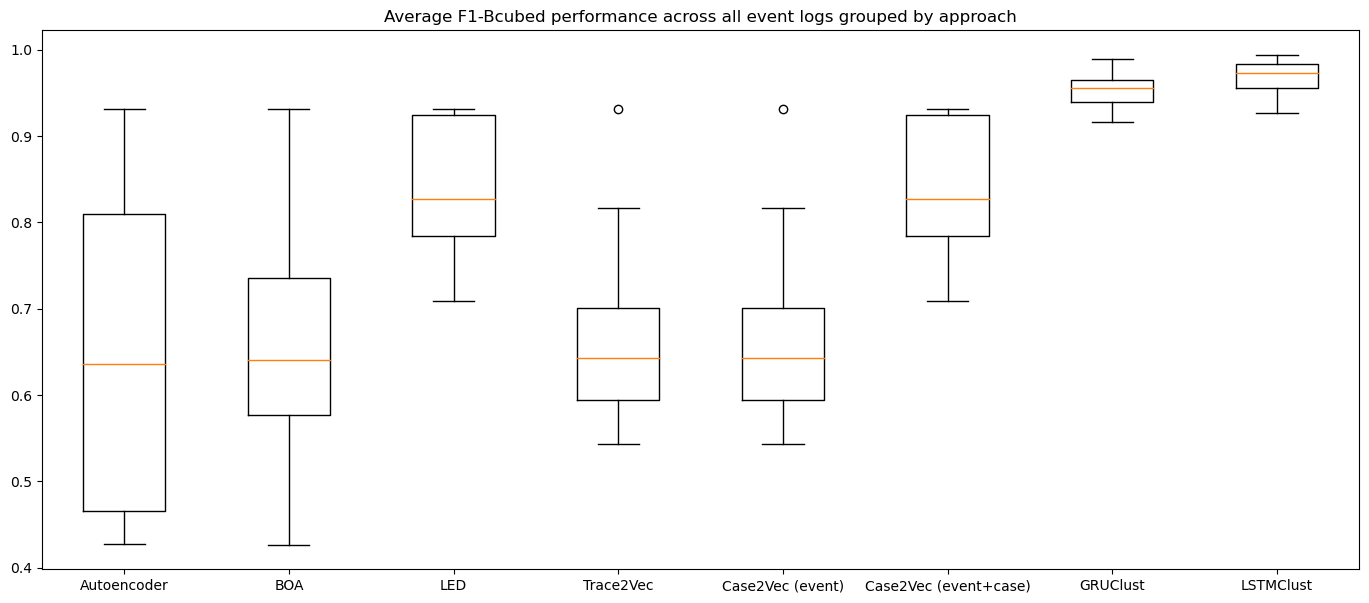

In [285]:
#plot
from matplotlib import pyplot as plt


fig = plt.figure(figsize =(17,7))
fig = plt.title("Average F1-Bcubed performance across all event logs grouped by approach")
results_of_algorithms = [results.get("autoencoder"), results.get("boa"), results.get("led"), results.get("trace2vec"),
                         results.get("case2vec_event"), results.get("case2vec_event_case"), results.get("gruclust"), results.get("lstmclust")]
#results_of_algorithms = [statistics_BOA.f1_bcubed, statistics_Trace2Vec.f1_bcubed, statistics_Case2Vec_event.f1_bcubed, statistics_Case2Vec_event_case.f1_bcubed, statistics_gruclust.f1_bcubed, statistics_lstmclust.f1_bcubed]

bp = plt.boxplot(results_of_algorithms , labels=['Autoencoder', 'BOA','LED', 'Trace2Vec','Case2Vec (event)', 'Case2Vec (event+case)', 'GRUClust', 'LSTMClust'])
plt.show()
# <<< USE TO PLOT HERE...



[0.5406267549556288, 0.4927537202926322, 0.5182344812487237, 0.5510675218974544, 0.5485608162911388, 0.5362135120988413, 0.5322020868851731, 0.5310764087082289, 0.5246448409796666, 0.5203003959318105, 0.3671867603819339]


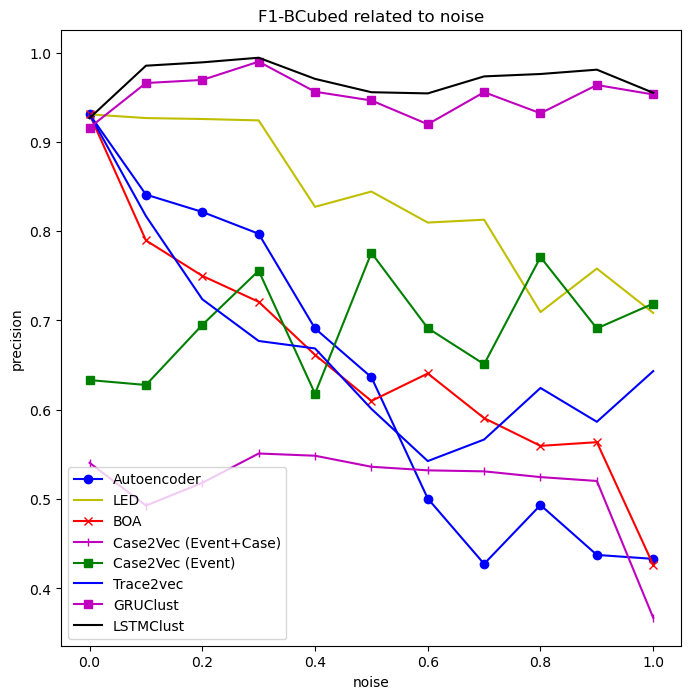

In [286]:
# F1-Bcubed-Results

fig_noise = plt.figure(figsize =(8,8))
fig_noise = plt.title("F1-BCubed related to noise")

results_autoencoder_f1_bcubed = []
results_led_f1_bcubed = []
results_boa_f1_bcubed = []
results_case2vec_event_case_f1_bcubed = []
results_case2vec_event_f1_bcubed = []
results_trace2vec_f1_bcubed = []
results_gru_f1_bcubed = []
results_lstm_f1_bcubed = []

ax1 = plt.subplot()
ax1.set_xlabel('noise')
ax1.set_ylabel('precision')

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_autoencoder[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_autoencoder_f1_bcubed.append(fitness)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_led[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_led_f1_bcubed.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_boa[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_boa_f1_bcubed.append(fitness)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_case2vec_event_f1_bcubed.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event_case[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_case2vec_event_case_f1_bcubed.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_trace2vec[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_trace2vec_f1_bcubed.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_gruclust[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_gru_f1_bcubed.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_lstmclust[i/10])
    fitness = statistics.f1_bcubed.mean()
    results_lstm_f1_bcubed.append(fitness)

noise = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
print(results_case2vec_event_case_f1_bcubed)

plt.plot(noise, results_autoencoder_f1_bcubed, '-bo', label='Autoencoder')
plt.plot(noise, results_led_f1_bcubed, '-y', label='LED')
plt.plot(noise, results_boa_f1_bcubed, '-rx', label='BOA')
plt.plot(noise, results_case2vec_event_case_f1_bcubed, '-m|', label='Case2Vec (Event+Case)')
plt.plot(noise, results_case2vec_event_f1_bcubed, '-gs', label='Case2Vec (Event)')
plt.plot(noise, results_trace2vec_f1_bcubed, '-b', label='Trace2vec')
plt.plot(noise, results_gru_f1_bcubed, '-ms', label='GRUClust')
plt.plot(noise, results_lstm_f1_bcubed, '-k', label='LSTMClust')


plt.legend()


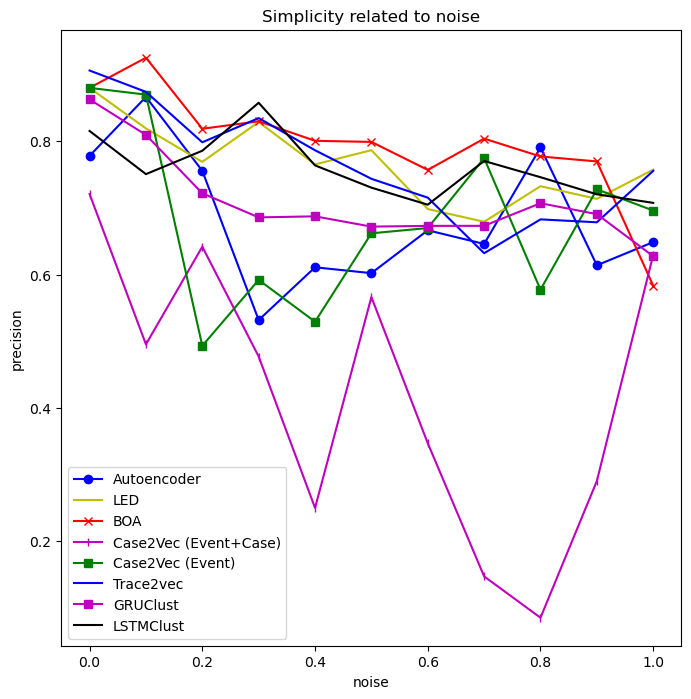

In [287]:
#  Simplicity Results
fig_noise = plt.figure(figsize =(8,8))
fig_noise = plt.title("Simplicity related to noise")

results_autoencoder_simplicity = []
results_led_simplicity = []
results_boa_simplicity = []
results_case2vec_event_case_simplicity = []
results_case2vec_event_simplicity = []
results_trace2vec_simplicity = []
results_gru_simplicity = []
results_lstm_simplicity = []

ax1 = plt.subplot()
ax1.set_xlabel('noise')
ax1.set_ylabel('precision')

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_autoencoder[i/10])
    fitness = statistics.simplicity.mean()
    results_autoencoder_simplicity.append(fitness)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_led[i/10])
    fitness = statistics.simplicity.mean()
    results_led_simplicity.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_boa[i/10])
    fitness = statistics.simplicity.mean()
    results_boa_simplicity.append(fitness)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event[i/10])
    fitness = statistics.simplicity.mean()
    results_case2vec_event_simplicity.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event_case[i/10])
    fitness = statistics.simplicity.mean()
    results_case2vec_event_case_simplicity.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_trace2vec[i/10])
    fitness = statistics.simplicity.mean()
    results_trace2vec_simplicity.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_gruclust[i/10])
    fitness = statistics.simplicity.mean()
    results_gru_simplicity.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_lstmclust[i/10])
    fitness = statistics.simplicity.mean()
    results_lstm_simplicity.append(fitness)

noise = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.plot(noise, results_autoencoder_simplicity, '-bo', label='Autoencoder')
plt.plot(noise, results_led_simplicity, '-y', label='LED')
plt.plot(noise, results_boa_simplicity, '-rx', label='BOA')
plt.plot(noise, results_case2vec_event_case_simplicity, '-m|', label='Case2Vec (Event+Case)')
plt.plot(noise, results_case2vec_event_simplicity, '-gs', label='Case2Vec (Event)')
plt.plot(noise, results_trace2vec_simplicity, '-b', label='Trace2vec')
plt.plot(noise, results_gru_simplicity, '-ms', label='GRUClust')
plt.plot(noise, results_lstm_simplicity, '-k', label='LSTMClust')


plt.legend()


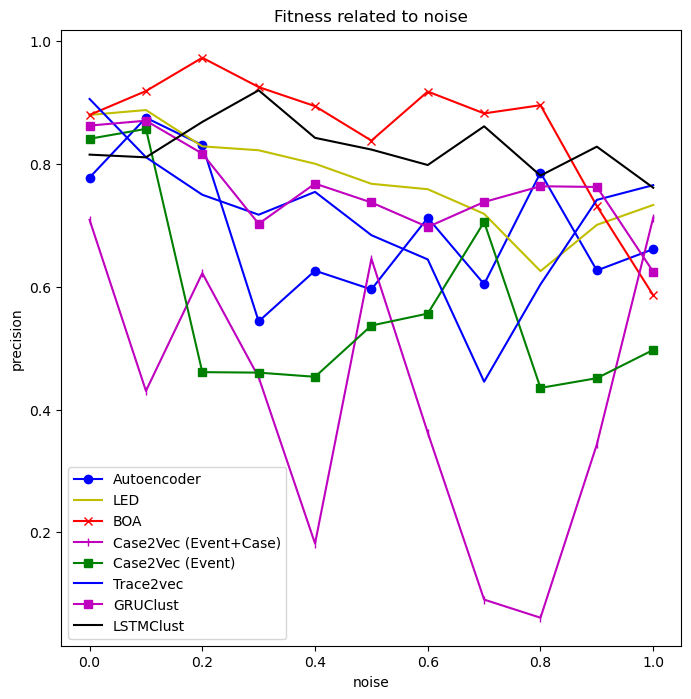

In [288]:
# Fitness Results

fig_noise = plt.figure(figsize =(8,8))
fig_noise = plt.title("Fitness related to noise")

results_autoencoder_fitness = []
results_led_fitness = []
results_boa_fitness = []
results_case2vec_event_case_fitness = []
results_case2vec_event_fitness = []
results_trace2vec_fitness = []
results_gru_fitness = []
results_lstm_fitness = []

ax1 = plt.subplot()
ax1.set_xlabel('noise')
ax1.set_ylabel('precision')

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_autoencoder[i/10])
    fitness = statistics.fitness.mean()
    results_autoencoder_fitness.append(fitness)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_led[i/10])
    fitness = statistics.fitness.mean()
    results_led_fitness.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_boa[i/10])
    fitness = statistics.fitness.mean()
    results_boa_fitness.append(fitness)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event[i/10])
    fitness = statistics.fitness.mean()
    results_case2vec_event_fitness.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event_case[i/10])
    fitness = statistics.fitness.mean()
    results_case2vec_event_case_fitness.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_trace2vec[i/10])
    fitness = statistics.fitness.mean()
    results_trace2vec_fitness.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_gruclust[i/10])
    fitness = statistics.fitness.mean()
    results_gru_fitness.append(fitness)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_lstmclust[i/10])
    fitness = statistics.fitness.mean()
    results_lstm_fitness.append(fitness)

noise = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.plot(noise, results_autoencoder_fitness, '-bo', label='Autoencoder')
plt.plot(noise, results_led_fitness, '-y', label='LED')
plt.plot(noise, results_boa_fitness, '-rx', label='BOA')
plt.plot(noise, results_case2vec_event_case_fitness, '-m|', label='Case2Vec (Event+Case)')
plt.plot(noise, results_case2vec_event_fitness, '-gs', label='Case2Vec (Event)')
plt.plot(noise, results_trace2vec_fitness, '-b', label='Trace2vec')
plt.plot(noise, results_gru_fitness, '-ms', label='GRUClust')
plt.plot(noise, results_lstm_fitness, '-k', label='LSTMClust')


plt.legend()


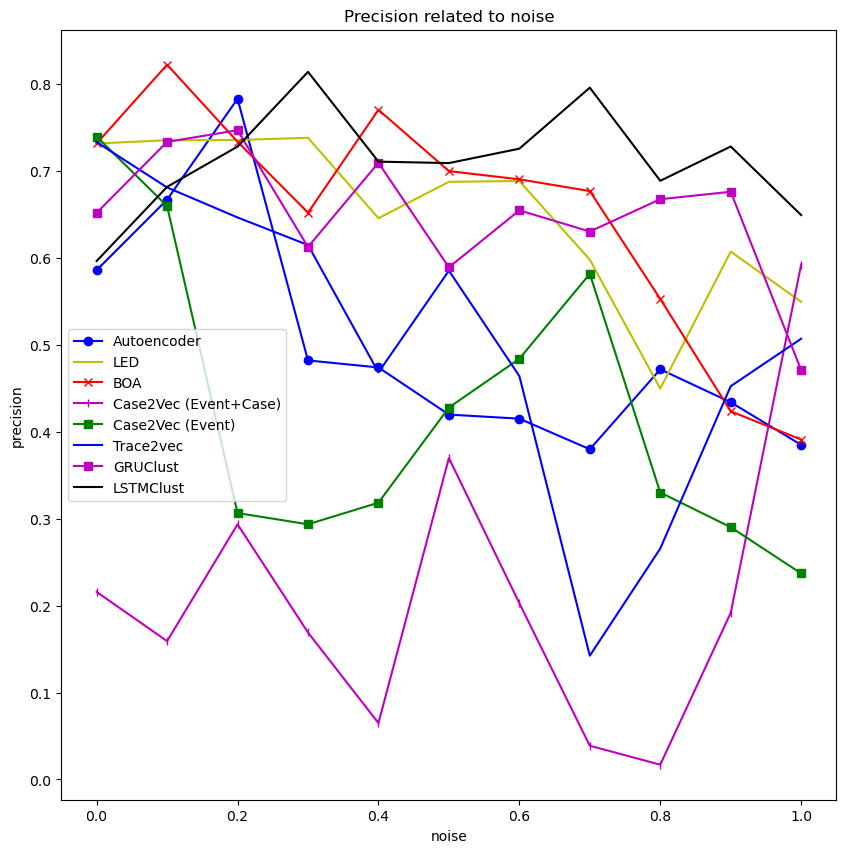

In [289]:
# Precision Results

fig_noise = plt.figure(figsize =(10,10))
fig_noise = plt.title("Precision related to noise")

results_autoencoder_precision = []
results_led_precision = []
results_boa_precision = []
results_case2vec_event_case_precision = []
results_case2vec_event_precision = []
results_trace2vec_precision = []
results_gru_precision = []
results_lstm_precision = []

ax1 = plt.subplot()
ax1.set_xlabel('noise')
ax1.set_ylabel('precision')

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_autoencoder[i/10])
    precision = statistics.precision.mean()
    results_autoencoder_precision.append(precision)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_led[i/10])
    precision = statistics.precision.mean()
    results_led_precision.append(precision)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_boa[i/10])
    precision = statistics.precision.mean()
    results_boa_precision.append(precision)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event[i/10])
    precision = statistics.precision.mean()
    results_case2vec_event_precision.append(precision)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event_case[i/10])
    precision = statistics.precision.mean()
    results_case2vec_event_case_precision.append(precision)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_trace2vec[i/10])
    precision = statistics.precision.mean()
    results_trace2vec_precision.append(precision)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_gruclust[i/10])
    precision = statistics.precision.mean()
    results_gru_precision.append(precision)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_lstmclust[i/10])
    precision = statistics.precision.mean()
    results_lstm_precision.append(precision)

noise = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.plot(noise, results_autoencoder_precision, '-bo', label='Autoencoder')
plt.plot(noise, results_led_precision, '-y', label='LED')
plt.plot(noise, results_boa_precision, '-rx', label='BOA')
plt.plot(noise, results_case2vec_event_case_precision, '-m|', label='Case2Vec (Event+Case)')
plt.plot(noise, results_case2vec_event_precision, '-gs', label='Case2Vec (Event)')
plt.plot(noise, results_trace2vec_precision, '-b', label='Trace2vec')
plt.plot(noise, results_gru_precision, '-ms', label='GRUClust')
plt.plot(noise, results_lstm_precision, '-k', label='LSTMClust')


plt.legend()


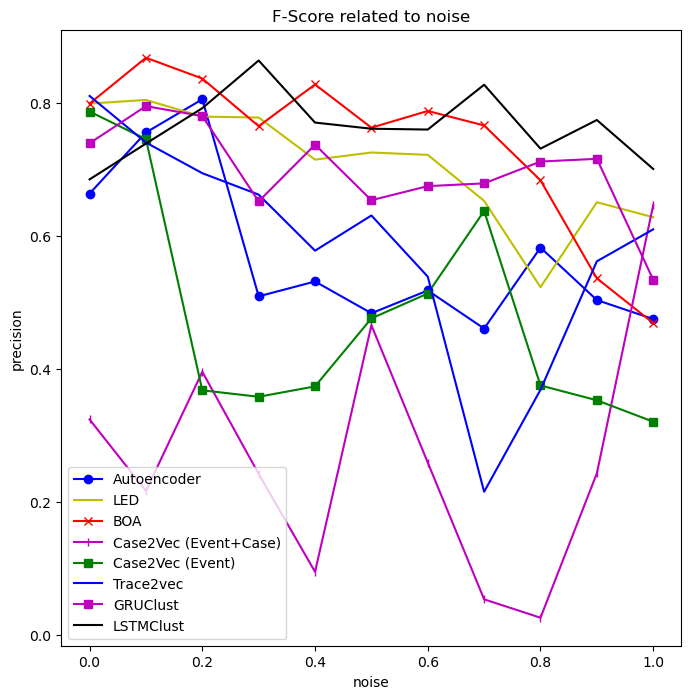

In [290]:
# F-Score Results

fig_noise = plt.figure(figsize =(8,8))
fig_noise = plt.title("F-Score related to noise")

results_autoencoder_f_score = []
results_led_f_score = []
results_boa_f_score = []
results_case2vec_event_case_f_score = []
results_case2vec_event_f_score = []
results_trace2vec_f_score = []
results_gru_f_score = []
results_lstm_f_score = []

ax1 = plt.subplot()
ax1.set_xlabel('noise')
ax1.set_ylabel('precision')

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_autoencoder[i/10])
    f_score = statistics.f_score.mean()
    results_autoencoder_f_score.append(f_score)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_led[i/10])
    f_score = statistics.f_score.mean()
    results_led_f_score.append(f_score)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_boa[i/10])
    f_score = statistics.f_score.mean()
    results_boa_f_score.append(f_score)
    
for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event[i/10])
    f_score = statistics.f_score.mean()
    results_case2vec_event_f_score.append(f_score)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_case2vec_event_case[i/10])
    f_score = statistics.f_score.mean()
    results_case2vec_event_case_f_score.append(f_score)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_trace2vec[i/10])
    f_score = statistics.f_score.mean()
    results_trace2vec_f_score.append(f_score)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_gruclust[i/10])
    f_score = statistics.f_score.mean()
    results_gru_f_score.append(f_score)

for i in range(11):
    statistics = pd.DataFrame.from_dict(results_lstmclust[i/10])
    f_score = statistics.f_score.mean()
    results_lstm_f_score.append(f_score)

noise = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.plot(noise, results_autoencoder_f_score, '-bo', label='Autoencoder')
plt.plot(noise, results_led_f_score, '-y', label='LED')
plt.plot(noise, results_boa_f_score, '-rx', label='BOA')
plt.plot(noise, results_case2vec_event_case_f_score, '-m|', label='Case2Vec (Event+Case)')
plt.plot(noise, results_case2vec_event_f_score, '-gs', label='Case2Vec (Event)')
plt.plot(noise, results_trace2vec_f_score, '-b', label='Trace2vec')
plt.plot(noise, results_gru_f_score, '-ms', label='GRUClust')
plt.plot(noise, results_lstm_f_score, '-k', label='LSTMClust')


plt.legend()

